# **E-commerce Customer Churn**

# Business Problem Understanding

**Context:**
<br>
Customer churn terjadi ketika pelanggan berhenti menggunakan layanan dari suatu perusahaan. Sebuah perusahaan e-commerce melakukan evaluasi terkait jumlah pengguna aktif pada aplikasinya. Berdasarkan hasil analisis data, terdapat penurunan jumlah aktivitas transaksi pelanggan di platform e-commerce, yang mengindikasikan potensi customer churn. Perusahaan ingin mengurangi tingkat churn dan menerapkan strategi retensi yang efektif dan efisien. Perusahaan memiliki dua piihan untuk mengatasi customer churn yaitu:
- Memberikan promo kepada semua pelanggan sebagai bagian dari strategi retensi, atau
- Tidak memberikan promo sama sekali, dengan risiko kehilangan pelanggan dan berdampak pada biaya akuisisi pelanggan baru lebih besar.
<br>
Perusahaan memilih untuk menerapkan strategi retensi dengan memberikan promo kepada pelanggan.

**Target:**
<br>
0 : Tidak churn
<br>
1 : Churn

**Problem Statement:**
<br>
Untuk menghindari terjadinya customer churn maka perusahaan perlu mengoptimalkan strategi retensi untuk mempertahankan pelanggan. Perusahaan juga perlu mengurangi risiko biaya retensi yang dikeluarkan yang kurang optimal akibat strategi retensi tidak tepat sasaran. Jika perusahaan memberikan promo kepada semua pelanggan maka biaya yang dikeluarkan akan sangat besar dan tidak efisien.

**Goals:**
<br>
Perusahaan melakukan prediksi customer churn dengan tujuan untuk menerapkan strategi retensi tepat sasaran kepada pelanggan yang mungkin churn. Selain itu, perusahaan ingin alokasi biaya retensi lebih efisien. Jika strategi retensi yang diterapkan tepat kepada pelanggan yang akan churn, maka dapat meminimalkan biaya retensi yang dikeluarkan sia-sia.

**Analytic Approach**
<br>
Yang akan dilakukan adalah menganalisis data dan membangun model klasifikasi yang dapat membantu perusahaan memprediksi pelanggan yang akan churn.

**Metric Evaluation**
<br>
- True Positive (TP) : Customer diprediksi churn dan aktualnya churn
- True Negative (TN) : Customer diprediksi tidak churn dan aktualnya tidak churn
- False Positive (FP): Customer diprediksi churn, tetapi aktualnya tidak churn. Asumsi biaya retensi sebesar $20
- False Negative (FN): Customer diprediksi tidak churn, tetapi aktualnya churn. Asumsi biaya akuisisi customer baru $100

- Konsekuensi FP: Biaya retensi yang dikeluarkan tidak tepat sasaran.
- Konsekuensi FN: Perusahaan kehilangan pelanggan lama dan harus mengakuisisi pelanggan baru.

Metrik yang digunakan adalah **F2-score** karena perusahaan memprioritaskan untuk mempertahankan pelanggan, namun tetap memperhatikan efisiensi biaya retensi yang dikeluarkan. Dengan asumsi biaya akuisisi akibat gagal mempertahankan pelanggan adalah lima kali lebih besar dibandingkan biaya retensi, maka metrik F2-score dipilih karena memberikan bobot lebih besar pada recall. Metrik F2-score memberi perhatian lebih besar kepada FN namun tetap mempertimbangkan FP.

# Data Understanding and Cleaning

**Attribute Information**

| Attribute | Data Type | Description |
| --- | --- | --- |
| Tenure | Float | Durasi pelanggan menggunakan e-commerce |
| WarehouseToHome | Float | Jarak antara gudang dan rumah pelanggan |
| NumberOfDeviceRegistered | Int | Jumlah perangkat yang didaftarkan oleh pelanggan pada platform e-commerce |
| PreferedOrderCat | Text | Kategori produk yang sering dipesan dalam satu bulan terakhir |
| SatisfactionScore | Int | Skor kepuasan pelanggan terhadap layanan |
| MaritalStatus | Text | Status pernikahan pelanggan |
| NumberOfAddress | Int | Jumlah alamat yang didaftarkan oleh pelanggan |
| Complain | Int | Keluhan yang diajukan pelanggan dalam satu bulan terakhir |
| DaySinceLastOrder | Float | Jumlah hari sejak pemesanan terakhir pelanggan |
| CashbackAmount | Float | Rata-rata cashback dalam satu bulan terakhir |
| Churn | Int | Status churn (berhenti menggunakan layanan). 0 : Tidak churn, 1 : Churn |

**Library:**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno

# Data splitting
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

# Data Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from category_encoders import OrdinalEncoder, BinaryEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.pipeline import Pipeline

# ML algorithm
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
import lightgbm as lgb

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Evaluation
from sklearn import metrics
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import shap

# save model
import pickle

import warnings
warnings.filterwarnings('ignore')

**Load dataset**

In [2]:
df = pd.read_csv('data_ecommerce_customer_churn.csv')
df

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
0,15.0,29.0,4,Laptop & Accessory,3,Single,2,0,7.0,143.32,0
1,7.0,25.0,4,Mobile,1,Married,2,0,7.0,129.29,0
2,27.0,13.0,3,Laptop & Accessory,1,Married,5,0,7.0,168.54,0
3,20.0,25.0,4,Fashion,3,Divorced,7,0,NaN,230.27,0
4,30.0,15.0,4,Others,4,Single,8,0,8.0,322.17,0
...,...,...,...,...,...,...,...,...,...,...,...
3936,28.0,9.0,5,Fashion,3,Married,8,0,1.0,231.86,0
3937,8.0,7.0,2,Mobile Phone,2,Single,4,0,4.0,157.80,0
3938,30.0,6.0,5,Laptop & Accessory,3,Married,3,1,2.0,156.60,0
3939,6.0,NaN,4,Mobile,3,Married,10,1,0.0,124.37,1


**Informasi dalam dataset**
- Jumlah baris, kolom, dan tipe data dalam dataset

In [3]:
print(f'Jumlah kolom dalam dataset : {df.shape[1]}')
print(f'Jumlah baris dalam dataset : {df.shape[0]}')
df.info()

Jumlah kolom dalam dataset : 11
Jumlah baris dalam dataset : 3941
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3941 entries, 0 to 3940
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Tenure                    3747 non-null   float64
 1   WarehouseToHome           3772 non-null   float64
 2   NumberOfDeviceRegistered  3941 non-null   int64  
 3   PreferedOrderCat          3941 non-null   object 
 4   SatisfactionScore         3941 non-null   int64  
 5   MaritalStatus             3941 non-null   object 
 6   NumberOfAddress           3941 non-null   int64  
 7   Complain                  3941 non-null   int64  
 8   DaySinceLastOrder         3728 non-null   float64
 9   CashbackAmount            3941 non-null   float64
 10  Churn                     3941 non-null   int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 338.8+ KB


- Jumlah data yang kosong atau missing values

In [4]:
df.isna().sum()

Tenure                      194
WarehouseToHome             169
NumberOfDeviceRegistered      0
PreferedOrderCat              0
SatisfactionScore             0
MaritalStatus                 0
NumberOfAddress               0
Complain                      0
DaySinceLastOrder           213
CashbackAmount                0
Churn                         0
dtype: int64

<Axes: >

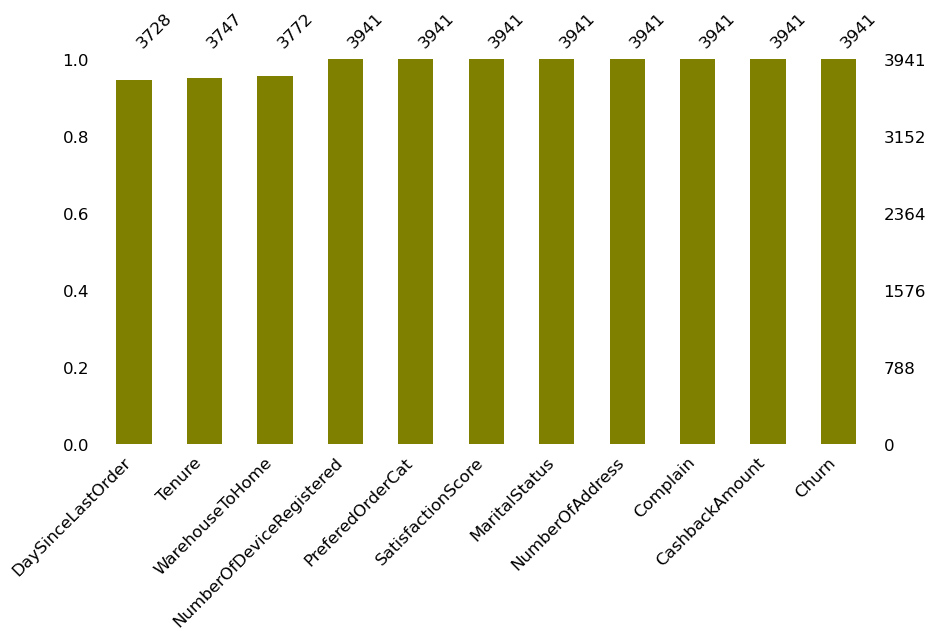

In [5]:
missingno.bar(df,color="olive", sort="ascending", figsize=(10,5), fontsize=12)

<Axes: >

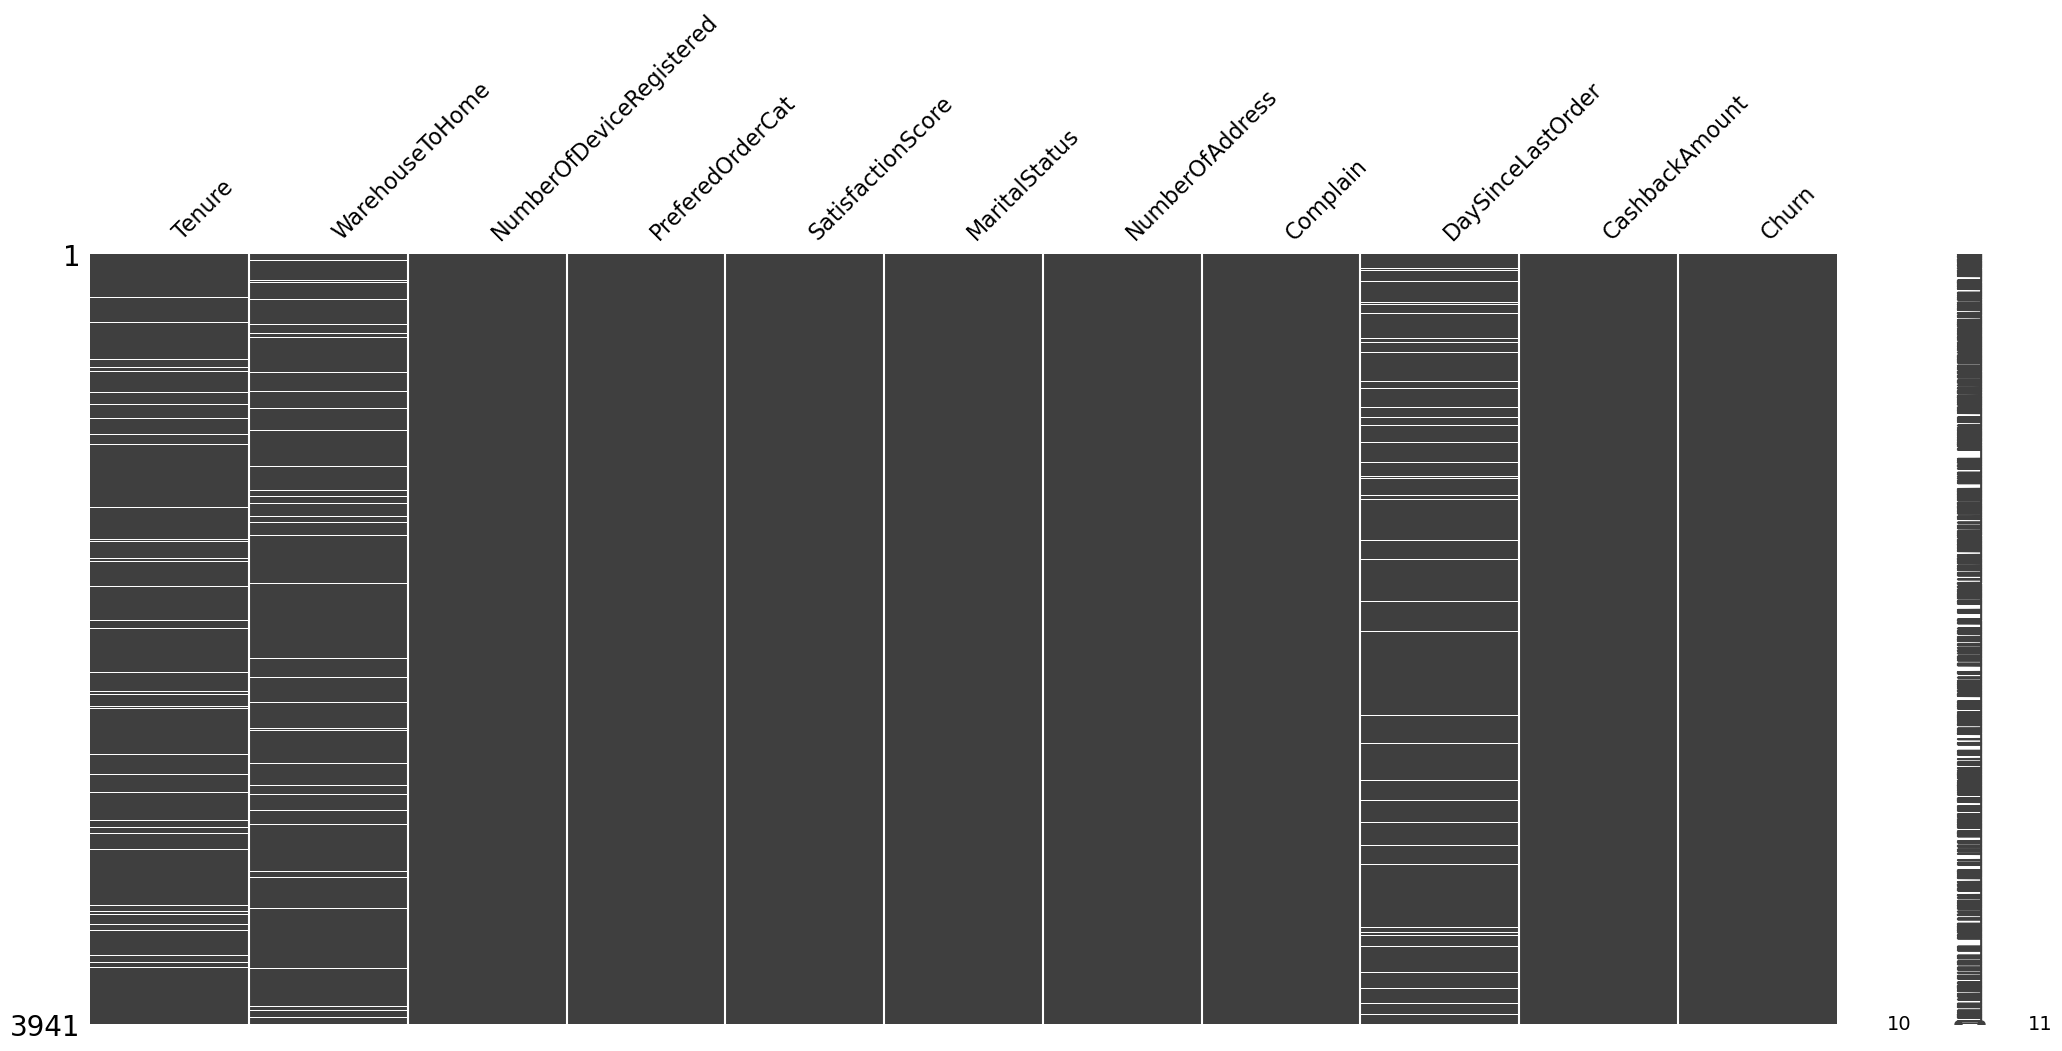

In [6]:
missingno.matrix(df)

- Jumlah data yang duplikat

In [7]:
df.duplicated().sum()

671

- Menghapus data yang duplikat

In [8]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [9]:
print(f'Jumlah baris : {df.shape[0]}')

Jumlah baris : 3270


Dalam dataset terdapat 11 kolom dan 3941 baris. Kolom Tenure memiliki 194 missing value, kolom WarehouseToHome memiliki 169 missing value, dan kolom DaySinceLastOrder memiliki 213 missing value. Penanganan missing value akan dilakukan pada tahap preprocessing. Selain itu, terdapat 671 data duplikat yang telah dihapus. Jumlah data yang akan digunakan adalah 3270 baris.

# Exploratory Data Analysis (EDA)

- **Jumlah nilai unik pada setiap kolom/fitur**

In [10]:
pd.set_option('display.max_colwidth', None)
listItem = []
for col in df.columns :
    listItem.append( [col, df[col].nunique(), df[col].unique()])

df_unique = pd.DataFrame(columns=['Nama Kolom', 'Jumlah nilai unik', 'Nilai Unik'],
                     data=listItem)
df_unique

,Nama Kolom,Jumlah nilai unik,Nilai Unik
0,Tenure,36,"[15.0, 7.0, 27.0, 20.0, 30.0, 1.0, 11.0, 17.0, 6.0, 16.0, 10.0, nan, 8.0, 19.0, 0.0, 3.0, 5.0, 9.0, 18.0, 12.0, 24.0, 4.0, 61.0, 25.0, 13.0, 14.0, 2.0, 21.0, 29.0, 26.0, 23.0, 31.0, 22.0, 28.0, 51.0, 60.0, 50.0]"
1,WarehouseToHome,33,"[29.0, 25.0, 13.0, 15.0, 16.0, 11.0, 12.0, 7.0, 26.0, 20.0, 14.0, 8.0, 21.0, 22.0, 27.0, 18.0, 33.0, 9.0, 17.0, nan, 6.0, 31.0, 28.0, 10.0, 19.0, 32.0, 23.0, 30.0, 35.0, 34.0, 24.0, 5.0, 36.0, 127.0]"
2,NumberOfDeviceRegistered,6,"[4, 3, 6, 2, 5, 1]"
3,PreferedOrderCat,6,"[Laptop & Accessory, Mobile, Fashion, Others, Mobile Phone, Grocery]"
4,SatisfactionScore,5,"[3, 1, 4, 2, 5]"
5,MaritalStatus,3,"[Single, Married, Divorced]"
6,NumberOfAddress,14,"[2, 5, 7, 8, 3, 1, 9, 4, 10, 11, 6, 19, 22, 21]"
7,Complain,2,"[0, 1]"
8,DaySinceLastOrder,22,"[7.0, nan, 8.0, 11.0, 2.0, 1.0, 4.0, 3.0, 6.0, 0.0, 14.0, 9.0, 10.0, 12.0, 5.0, 17.0, 30.0, 18.0, 16.0, 13.0, 15.0, 46.0, 31.0]"
9,CashbackAmount,2335,"[143.32, 129.29, 168.54, 230.27, 322.17, 152.81, 149.51, 154.73, 137.02, 157.43, 221.1, 180.38, 154.09, 231.09, 163.92, 193.15, 121.68, 204.78, 259.96, 127.16, 191.96, 153.01, 126.7, 189.98, 205.95, 148.5, 175.1, 124.32, 204.82, 228.06, 196.13, 205.52, 262.44, 125.46, 123.67, 123.22, 264.73, 122.18, 141.94, 172.87, 139.29, 207.48, 208.92, 296.59, 120.08, 197.64, 151.95, 171.8, 174.84, 152.96, 140.11, 303.75, 226.24, 265.55, 156.47, 179.84, 145.29, 123.68, 268.36, 154.29, 125.64, 144.78, 129.11, 165.31, 135.81, 148.4, 149.5, 136.6, 204.35, 208.46, 125.17, 217.41, 224.9, 211.21, 143.93, 146.68, 167.49, 149.0, 163.49, 145.38, 190.24, 140.69, 188.58, 222.13, 122.7, 141.98, 145.97, 262.34, 140.25, 219.04, 197.56, 179.91, 120.75, 189.66, 110.91, 188.37, 239.16000000000005, 145.08, 179.88, 127.78, ...]"


- **Proporsi data target Churn**

In [11]:
df['Churn'].value_counts() / len(df['Churn'])

Churn
0    0.836697
1    0.163303
Name: count, dtype: float64

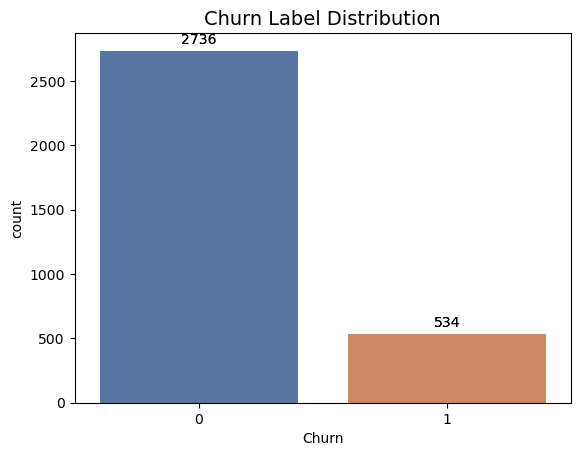

In [12]:
sns.countplot(df, x='Churn')

data_proportion = sns.countplot(data=df, x='Churn', palette='deep')
for x in data_proportion.patches:
    data_proportion.annotate(f'{x.get_height():.0f}', 
                   (x.get_x() + x.get_width() / 2, 
                    x.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')
plt.title('Churn Label Distribution', fontsize=14)
plt.xticks(rotation=0, fontsize=10)
plt.show()

Proporsi dataset tidak seimbang (imbalanced). Data target `Churn` terdiri dari 2736 label 0 (tidak churn) dan 534 label 1 (churn). Persentase label 0 sebesar 83% dan label 1 sebesar 17%.

- **Ringkasan statistik deskriptif fitur dalam dataset**

In [13]:
df.describe(include='all')

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
count,3110.000000,3135.000000,3270.000000,3270,3270.000000,3270,3270.000000,3270.000000,3089.000000,3270.000000,3270.000000
unique,NaN,NaN,NaN,6,NaN,3,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,Laptop & Accessory,NaN,Married,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,1213,NaN,1686,NaN,NaN,NaN,NaN,NaN
mean,10.190354,15.510367,3.676453,NaN,3.020795,NaN,4.222936,0.281651,4.545484,177.417670,0.163303
std,8.650821,8.568382,1.017390,NaN,1.395113,NaN,2.623195,0.449873,3.696022,49.310647,0.369698
min,0.000000,5.000000,1.000000,NaN,1.000000,NaN,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,9.000000,3.000000,NaN,2.000000,NaN,2.000000,0.000000,2.000000,145.892500,0.000000
50%,9.000000,13.000000,4.000000,NaN,3.000000,NaN,3.000000,0.000000,3.000000,163.885000,0.000000
75%,16.000000,20.000000,4.000000,NaN,4.000000,NaN,6.000000,1.000000,7.000000,197.137500,0.000000


- **Identifikasi outlier pada setiap fitur**

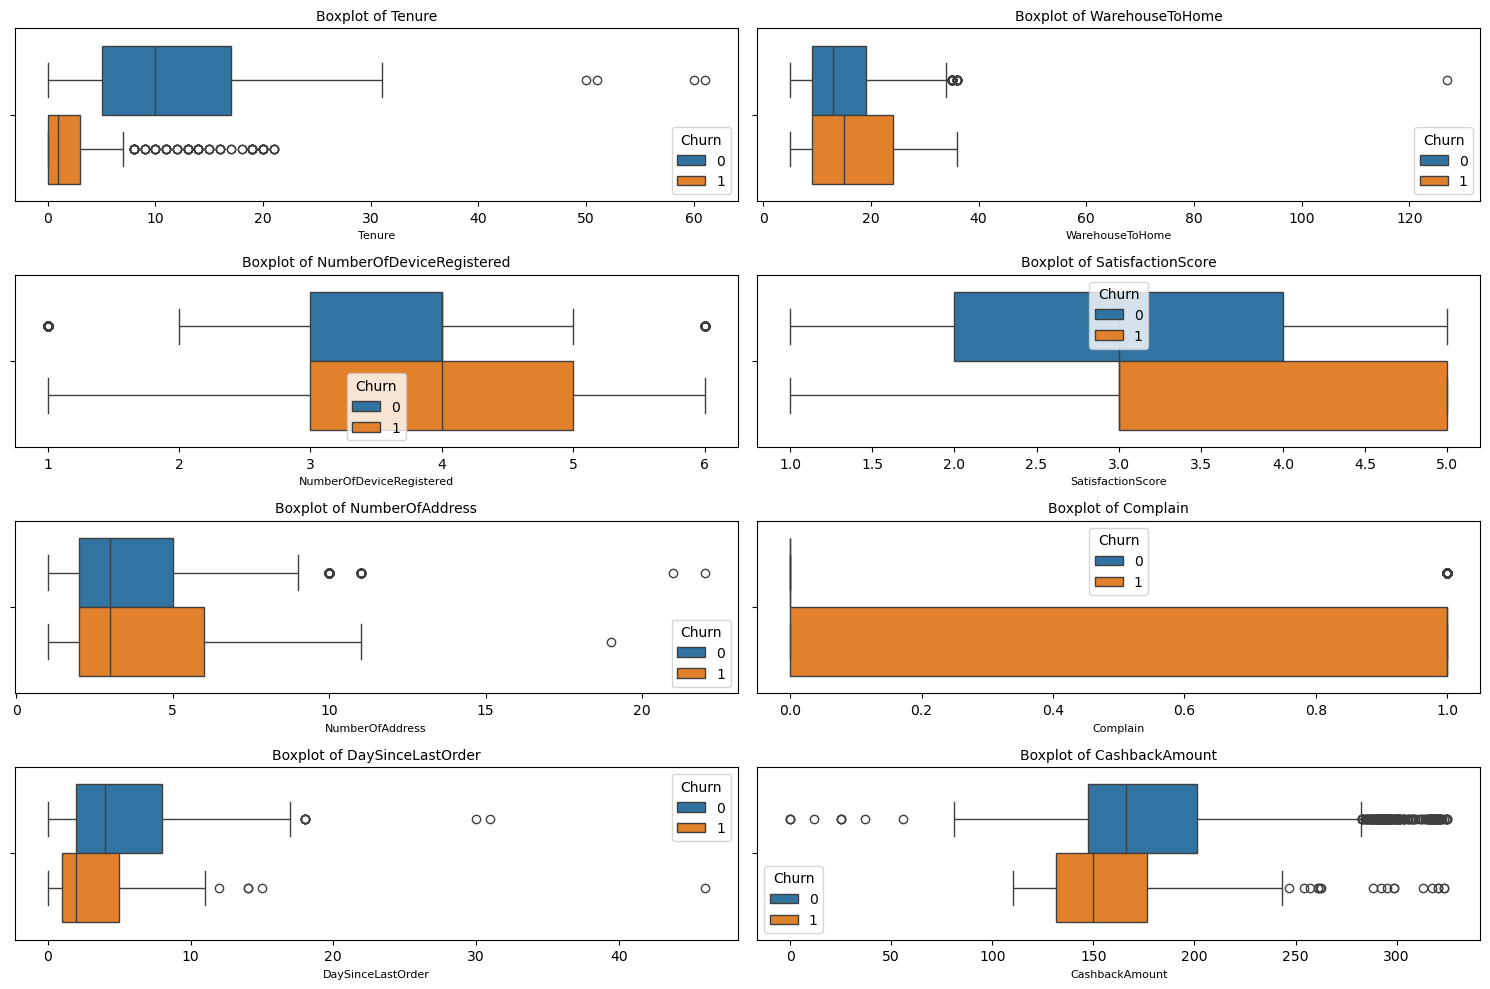

In [14]:
feat_num= df.drop(columns=['PreferedOrderCat', 'MaritalStatus', 'Churn'])

fig, axes = plt.subplots(4, 2, figsize=(15, 10))
axes=axes.flatten()

for i, column in enumerate(feat_num):
    sns.boxplot(data=df, x=column, ax=axes[i], hue='Churn')
    axes[i].set_title(f'Boxplot of {column}', fontsize=10)
    axes[i].set_xlabel(column, fontsize=8)

plt.tight_layout()
plt.show()

In [15]:
for i in feat_num:
    Q1 = df[i].describe()['25%']
    Q3 = df[i].describe()['75%']
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outlier_count = ((df[i] < lower) | (df[i] > upper)).sum()
    print(f'Jumlah outlier {i}: {outlier_count}')

Jumlah outlier Tenure: 4
Jumlah outlier WarehouseToHome: 1
Jumlah outlier NumberOfDeviceRegistered: 226
Jumlah outlier SatisfactionScore: 0
Jumlah outlier NumberOfAddress: 3
Jumlah outlier Complain: 0
Jumlah outlier DaySinceLastOrder: 40
Jumlah outlier CashbackAmount: 253


Dalam dataset terdapat beberapa fitur yang memiliki outlier. Scaling yang akan digunakan adalah RobustScaler karena tidak sensitif terhadap outlier.

- **Distribusi data pada setiap fitur**

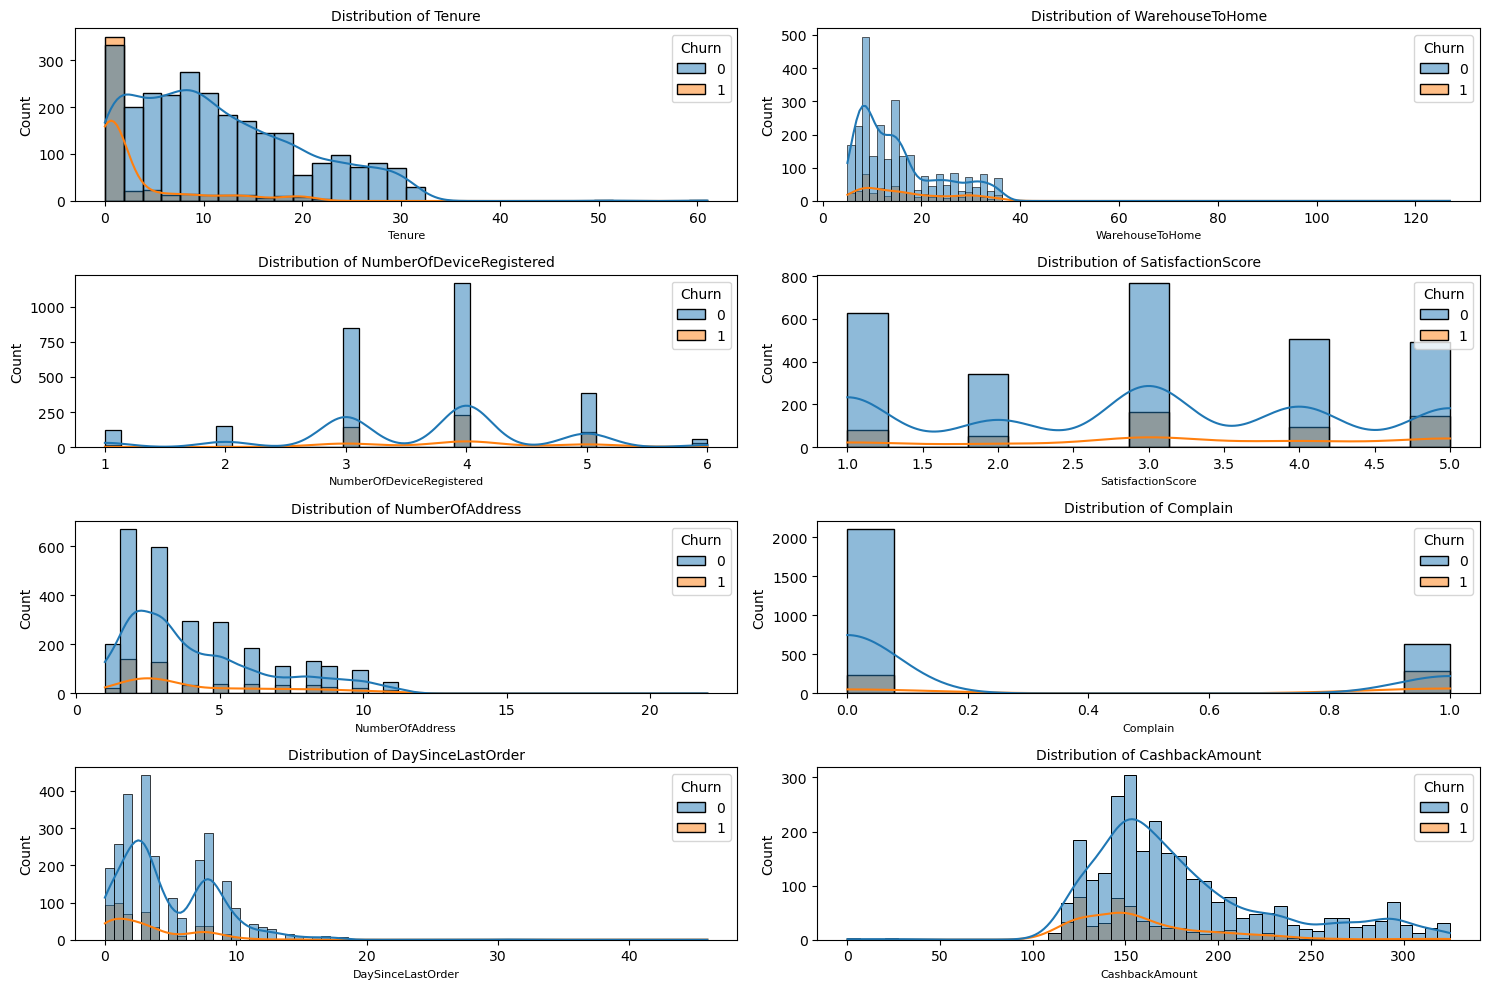

In [16]:
fig, axes = plt.subplots(4, 2, figsize=(15, 10))
axes=axes.flatten()

for i, column in enumerate(feat_num):
    sns.histplot(data=df, x=column, ax=axes[i], kde=True, hue='Churn')
    axes[i].set_title(f'Distribution of {column}', fontsize=10)
    axes[i].set_xlabel(column, fontsize=8)

plt.tight_layout()
plt.show()

- **Heatmap**

Text(0.5, 1.0, 'Correlation Heatmap')

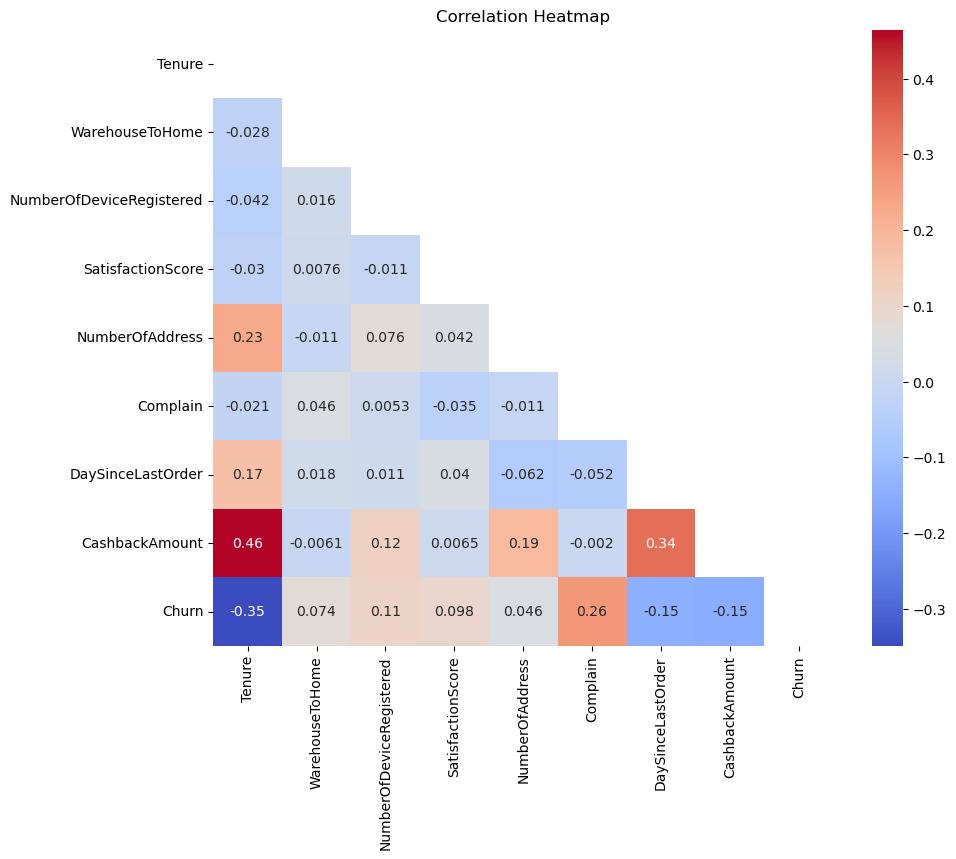

In [17]:
num_feature = df.drop(columns=['PreferedOrderCat', 'MaritalStatus'])
corr = num_feature.corr()

matrix_upper = np.triu(corr)
matrix_upper

plt.figure(figsize=(10,8))

sns.heatmap(data=corr, annot=True, cmap='coolwarm', mask=matrix_upper)

plt.title('Correlation Heatmap')

Interpretasi:

Fitur yang memiliki nilai korelasi paling tinggi dengan Churn adalah Tenure dan Complain. Fitur lainnya memiliki korelasi yang sangat lemah dengan churn.
<br>
- Churn dan Tenure memiliki nilai korelasi sebesar -0.35 yang berarti korelasinya lemah dan hubungannya negatif (semakin baru pelanggan menjadi pengguna platform e-commerce maka cenderung akan churn). 
<br>
- Churn dan Complain memiliki nilai korelasi sebesar 0.26 yang berarti korelasinya lemah dan hubungannya positif (pelanggan yang komplain cenderung akan churn).

- **Churn rate pada setiap fitur**

Churn rate by `Tenure`

Churn,0,1,total,churn_rate_tenure (%)
Tenure_range,,,,
0 - 15,1845.0,458.0,2303.0,19.89
16 - 30,745.0,28.0,773.0,3.62
31 - 45,30.0,NaN,30.0,NaN
45 - 61,4.0,NaN,4.0,NaN


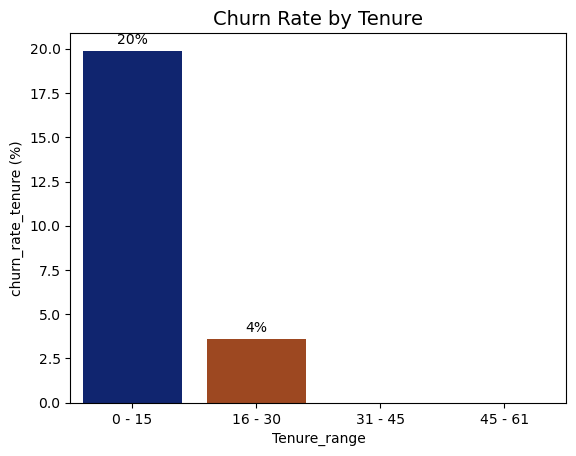

In [18]:
df2 = df.copy()
df2['No.'] = df2.index

def tenure_range(i):
    if 0 <= i <= 15:
        return '0 - 15'
    elif 15 < i <= 30:
        return '16 - 30'
    elif 30 < i <= 45:
        return '31 - 45'
    elif 45 < i <= 61:
        return '45 - 61'
  

df2['Tenure_range'] = df2['Tenure'].apply(tenure_range)
df_pivot_tenure = pd.pivot_table(data = df2,
               index = 'Tenure_range',
               columns = 'Churn',
               values='No.',
               aggfunc=len)
df_pivot_tenure['total'] = df_pivot_tenure.sum(axis=1)
df_pivot_tenure['churn_rate_tenure (%)'] = ((df_pivot_tenure[1] / df_pivot_tenure['total'])* 100).round(2)
display(df_pivot_tenure)


pivot_tenure = sns.barplot(df_pivot_tenure, x='Tenure_range', y='churn_rate_tenure (%)', palette='dark')
for x in pivot_tenure.patches:
    pivot_tenure.annotate(f'{x.get_height():.0f}%', 
                   (x.get_x() + x.get_width() / 2, 
                    x.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')
plt.title('Churn Rate by Tenure', fontsize=14)
plt.xticks(rotation=0, fontsize=10)
plt.show()

Churn rate by `WarehouseToHome`

Churn,0,1,total,churn_rate_wth (%)
WarehouseToHome_range,,,,
0 - 9,890,135,1025,13.17
10 - 18,1066,175,1241,14.10
19 - 27,364,85,449,18.93
28 - 36,325,94,419,22.43
> 36,91,45,136,33.09


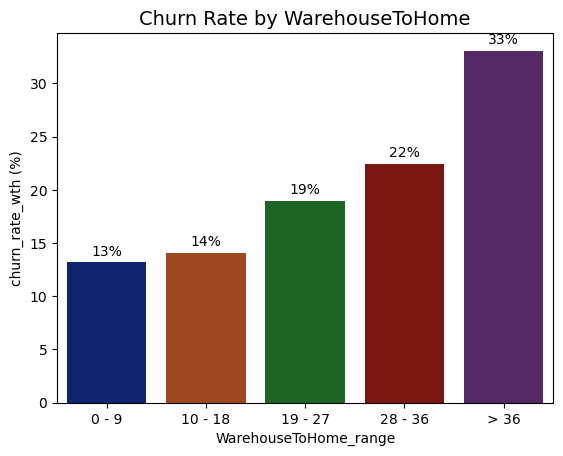

In [19]:
def wth_range(i):
    if 0 <= i <= 9:
        return '0 - 9'
    elif 9 < i <= 18:
        return '10 - 18'
    elif 18 < i <= 27:
        return '19 - 27'
    elif 27 < i <= 36:
        return '28 - 36'
    else:
        return '> 36'
  

df2['WarehouseToHome_range'] = df2['WarehouseToHome'].apply(wth_range)
df_pivot_wth = pd.pivot_table(data = df2,
               index = 'WarehouseToHome_range',
               columns = 'Churn',
               values='No.',
               aggfunc=len)
df_pivot_wth['total'] = df_pivot_wth.sum(axis=1)
df_pivot_wth['churn_rate_wth (%)'] = ((df_pivot_wth[1] / df_pivot_wth['total'])*100).round(2) 
display(df_pivot_wth)


pivot_wth = sns.barplot(df_pivot_wth, x='WarehouseToHome_range', y='churn_rate_wth (%)', palette='dark')
for x in pivot_wth.patches:
    pivot_wth.annotate(f'{x.get_height():.0f}%', 
                   (x.get_x() + x.get_width() / 2, 
                    x.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')
plt.title('Churn Rate by WarehouseToHome', fontsize=14)
plt.xticks(rotation=0, fontsize=10)
plt.show()

Churn rate by `NumberOfDeviceRegistered`

Churn,0,1,total,churn_rate_device (%)
NumberOfDeviceRegistered,,,,
1,123,14,137,10.22
2,151,12,163,7.36
3,850,142,992,14.31
4,1170,226,1396,16.19
5,383,110,493,22.31
6,59,30,89,33.71


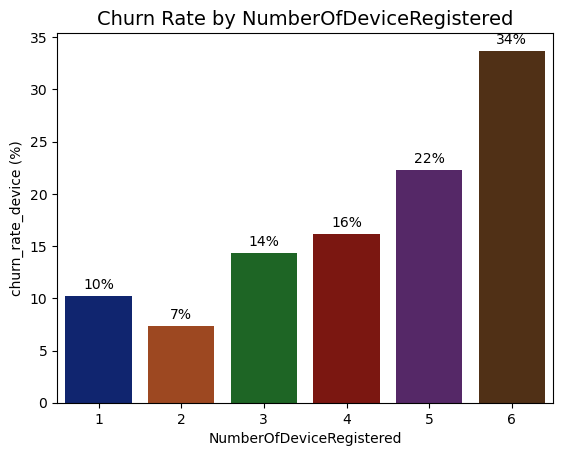

In [20]:
df_pivot_device = pd.pivot_table(data = df2,
               index = 'NumberOfDeviceRegistered',
               columns = 'Churn',
               values='No.',
               aggfunc=len)
df_pivot_device['total'] = df_pivot_device.sum(axis=1)
df_pivot_device['churn_rate_device (%)'] = ((df_pivot_device[1] / df_pivot_device['total'])*100).round(2)
display(df_pivot_device)


pivot_device = sns.barplot(df_pivot_device, x='NumberOfDeviceRegistered', y='churn_rate_device (%)', palette='dark')
for x in pivot_device.patches:
    pivot_device.annotate(f'{x.get_height():.0f}%', 
                   (x.get_x() + x.get_width() / 2, 
                    x.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')
plt.title('Churn Rate by NumberOfDeviceRegistered', fontsize=14)
plt.xticks(rotation=0, fontsize=10)
plt.show()

Churn rate by `PreferedOrderCat`

Churn,0,1,total,churn_rate_cat (%)
PreferedOrderCat,,,,
Fashion,409,75,484,15.50
Grocery,231,10,241,4.15
Laptop & Accessory,1094,119,1213,9.81
Mobile,334,124,458,27.07
Mobile Phone,530,195,725,26.90
Others,138,11,149,7.38


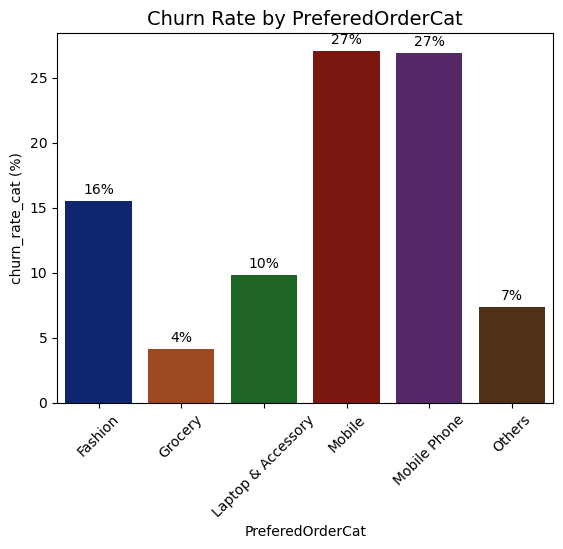

In [21]:
df_pivot_cat = pd.pivot_table(data = df2,
               index = 'PreferedOrderCat',
               columns = 'Churn',
               values='No.',
               aggfunc=len)
df_pivot_cat['total'] = df_pivot_cat.sum(axis=1)
df_pivot_cat['churn_rate_cat (%)'] = ((df_pivot_cat[1] / df_pivot_cat['total'])*100).round(2)
display(df_pivot_cat)


pivot_cat = sns.barplot(df_pivot_cat, x='PreferedOrderCat', y='churn_rate_cat (%)', palette='dark')
for x in pivot_cat.patches:
    pivot_cat.annotate(f'{x.get_height():.0f}%', 
                   (x.get_x() + x.get_width() / 2, 
                    x.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')
plt.title('Churn Rate by PreferedOrderCat', fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.show()

Churn rate by `SatisfactionScore`

Churn,0,1,total,churn_rate_ss (%)
SatisfactionScore,,,,
1,628,79,707,11.17
2,341,51,392,13.01
3,769,163,932,17.49
4,508,96,604,15.89
5,490,145,635,22.83


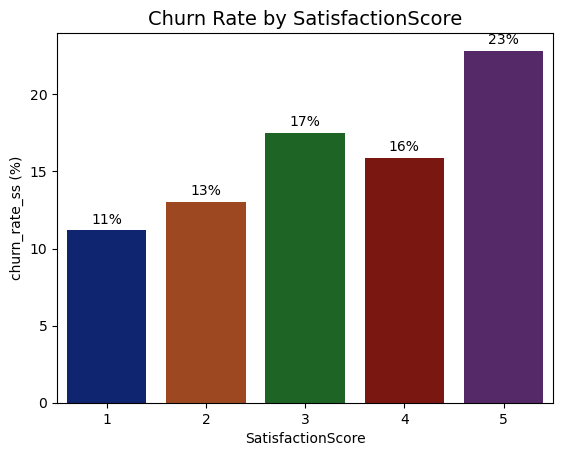

In [22]:
df_pivot_ss = pd.pivot_table(data = df2,
               index = 'SatisfactionScore',
               columns = 'Churn',
               values='No.',
               aggfunc=len)
df_pivot_ss['total'] = df_pivot_ss.sum(axis=1)
df_pivot_ss['churn_rate_ss (%)'] = ((df_pivot_ss[1] / df_pivot_ss['total'])*100).round(2) 
display(df_pivot_ss)


pivot_ss = sns.barplot(df_pivot_ss, x='SatisfactionScore', y='churn_rate_ss (%)', palette='dark')
for x in pivot_ss.patches:
    pivot_ss.annotate(f'{x.get_height():.0f}%', 
                   (x.get_x() + x.get_width() / 2, 
                    x.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')
plt.title('Churn Rate by SatisfactionScore', fontsize=14)
plt.xticks(rotation=0, fontsize=10)
plt.show()

Churn rate by `MaritalStatus`

Churn,0,1,total,churn_rate_marital (%)
MaritalStatus,,,,
Divorced,487,89,576,15.45
Married,1502,184,1686,10.91
Single,747,261,1008,25.89


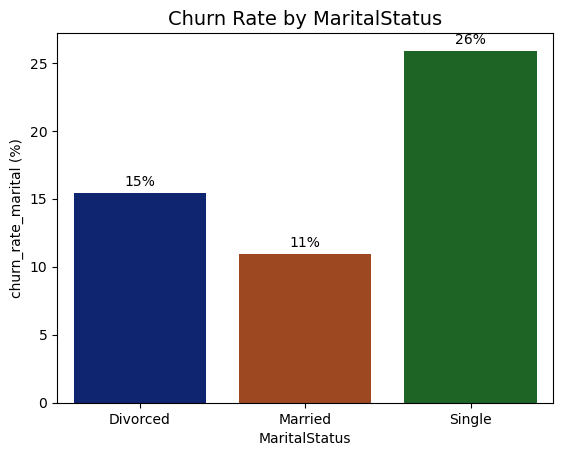

In [23]:
df_pivot_marital = pd.pivot_table(data = df2,
               index = 'MaritalStatus',
               columns = 'Churn',
               values='No.',
               aggfunc=len)
df_pivot_marital['total'] = df_pivot_marital.sum(axis=1)
df_pivot_marital['churn_rate_marital (%)'] = ((df_pivot_marital[1] / df_pivot_marital['total'])*100).round(2) 
display(df_pivot_marital)


pivot_marital = sns.barplot(df_pivot_marital, x='MaritalStatus', y='churn_rate_marital (%)', palette='dark')
for x in pivot_marital.patches:
    pivot_marital.annotate(f'{x.get_height():.0f}%', 
                   (x.get_x() + x.get_width() / 2, 
                    x.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')
plt.title('Churn Rate by MaritalStatus', fontsize=14)
plt.xticks(rotation=0, fontsize=10)
plt.show()

Churn rate by `NumberOfAddress`

Churn,0,1,total,churn_rate_address (%)
NumberOfAddress_range,,,,
0 - 4,1764,324,2088,15.52
5 - 8,718,146,864,16.90
9 - 12,252,63,315,20.00
> 12,2,1,3,33.33


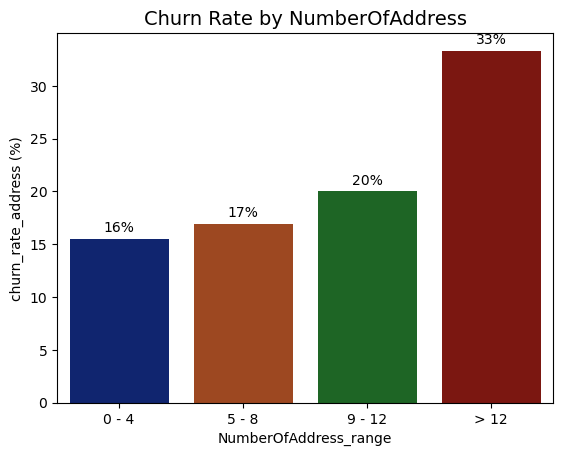

In [24]:
def address_range(i):
    if 0 <= i <= 4:
        return '0 - 4'
    elif 4 < i <= 8:
        return '5 - 8'
    elif 8 < i <= 12:
        return '9 - 12'
    else:
        return '> 12'

df2['NumberOfAddress_range'] = df2['NumberOfAddress'].apply(address_range)

df_pivot_address = pd.pivot_table(data = df2,
               index = 'NumberOfAddress_range',
               columns = 'Churn',
               values='No.',
               aggfunc=len)
df_pivot_address['total'] = df_pivot_address.sum(axis=1)
df_pivot_address['churn_rate_address (%)'] = ((df_pivot_address[1] / df_pivot_address['total'])*100).round(2)
display(df_pivot_address)


pivot_address = sns.barplot(df_pivot_address, x='NumberOfAddress_range', y='churn_rate_address (%)', palette='dark')
for x in pivot_address.patches:
    pivot_address.annotate(f'{x.get_height():.0f}%', 
                   (x.get_x() + x.get_width() / 2, 
                    x.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')
plt.title('Churn Rate by NumberOfAddress', fontsize=14)
plt.xticks(rotation=0, fontsize=10)
plt.show()

Churn rate by `Complain`

Churn,0,1,total,churn_rate_complain (%)
Complain,,,,
0,2108,241,2349,10.26
1,628,293,921,31.81


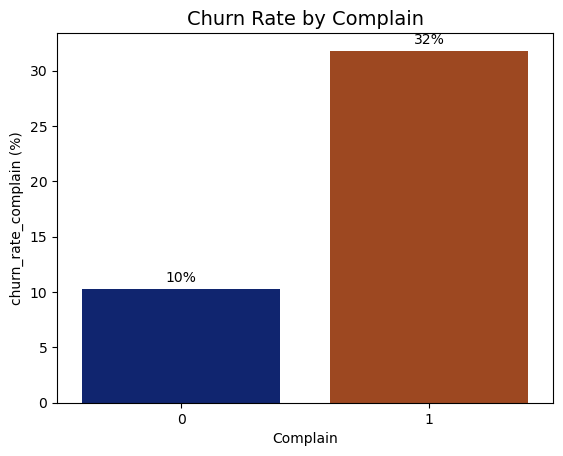

In [25]:
df_pivot_complain = pd.pivot_table(data = df2,
               index = 'Complain',
               columns = 'Churn',
               values='No.',
               aggfunc=len)
df_pivot_complain['total'] = df_pivot_complain.sum(axis=1)
df_pivot_complain['churn_rate_complain (%)'] = ((df_pivot_complain[1] / df_pivot_complain['total'])*100).round(2) 
display(df_pivot_complain)


pivot_complain = sns.barplot(df_pivot_complain, x='Complain', y='churn_rate_complain (%)', palette='dark')
for x in pivot_complain.patches:
    pivot_complain.annotate(f'{x.get_height():.0f}%', 
                   (x.get_x() + x.get_width() / 2, 
                    x.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')
plt.title('Churn Rate by Complain', fontsize=14)
plt.xticks(rotation=0, fontsize=10)
plt.show()

Churn rate by `DaySinceLastOrder`

Churn,0,1,total,churn_rate_lastorder (%)
DaySinceLastOrder_range,,,,
0 - 10,2426.0,495.0,2921.0,16.95
11 - 20,157.0,8.0,165.0,4.85
21 - 30,1.0,NaN,1.0,NaN
31 - 40,1.0,NaN,1.0,NaN
> 40,151.0,31.0,182.0,17.03


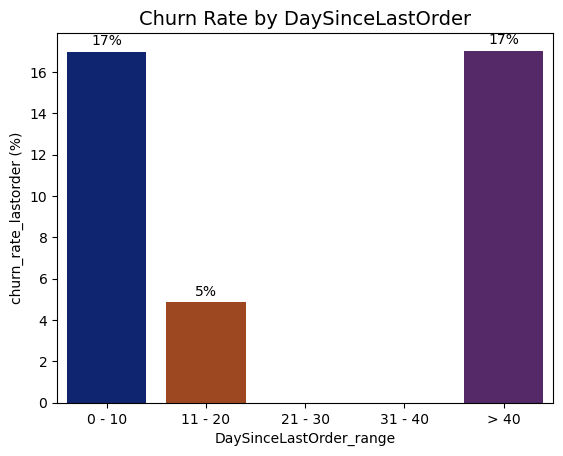

In [26]:
def DaySinceLastOrder_range(i):
    if 0 <= i <= 10:
        return '0 - 10'
    elif 10 < i <= 20:
        return '11 - 20'
    elif 10 < i <= 30:
        return '21 - 30'
    elif 30 < i <= 40:
        return '31 - 40'
    else:
        return '> 40'

df2['DaySinceLastOrder_range'] = df2['DaySinceLastOrder'].apply(DaySinceLastOrder_range)
df_pivot_lastorder = pd.pivot_table(data = df2,
               index = 'DaySinceLastOrder_range',
               columns = 'Churn',
               values='No.',
               aggfunc=len)
df_pivot_lastorder['total'] = df_pivot_lastorder.sum(axis=1)
df_pivot_lastorder['churn_rate_lastorder (%)'] = ((df_pivot_lastorder[1] / df_pivot_lastorder['total'])*100).round(2) 
display(df_pivot_lastorder)


pivot_lastorder = sns.barplot(df_pivot_lastorder, x='DaySinceLastOrder_range', y='churn_rate_lastorder (%)', palette='dark')
for x in pivot_lastorder.patches:
    pivot_lastorder.annotate(f'{x.get_height():.0f}%', 
                   (x.get_x() + x.get_width() / 2, 
                    x.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')
plt.title('Churn Rate by DaySinceLastOrder', fontsize=14)
plt.xticks(rotation=0, fontsize=10)
plt.show()

Churn rate by `CashbackAmount`

Churn,0,1,total,churn_rate_cashback (%)
cashback_range,,,,
0 - 80,9.0,NaN,9.0,NaN
161 - 240,1181.0,172.0,1353.0,12.71
241 - 320,355.0,16.0,371.0,4.31
81 - 160,1170.0,342.0,1512.0,22.62
> 320,21.0,4.0,25.0,16.00


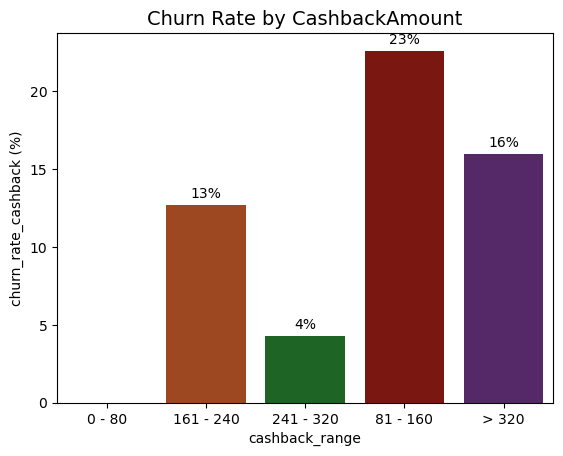

In [27]:
def cashback_range(i):
    if 0 <= i <= 80:
        return '0 - 80'
    elif 80 < i <= 160:
        return '81 - 160'
    elif 160 < i <= 240:
        return '161 - 240'
    elif 240 < i <= 320:
        return '241 - 320'
    else:
        return '> 320'

df2['cashback_range'] = df2['CashbackAmount'].apply(cashback_range)
df_pivot_cashback = pd.pivot_table(data = df2,
               index = 'cashback_range',
               columns = 'Churn',
               values='No.',
               aggfunc=len)
df_pivot_cashback['total'] = df_pivot_cashback.sum(axis=1)
df_pivot_cashback['churn_rate_cashback (%)'] = ((df_pivot_cashback[1] / df_pivot_cashback['total'])*100).round(2) 
display(df_pivot_cashback)


pivot_cashback = sns.barplot(df_pivot_cashback, x='cashback_range', y='churn_rate_cashback (%)', palette='dark')
for x in pivot_cashback.patches:
    pivot_cashback.annotate(f'{x.get_height():.0f}%', 
                   (x.get_x() + x.get_width() / 2, 
                    x.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')
plt.title('Churn Rate by CashbackAmount', fontsize=14)
plt.xticks(rotation=0, fontsize=10)
plt.show()

Interpretasi:
- Churn rate by `Tenure`: Pelanggan yang belum lama menjadi pelanggan cenderung untuk churn.

- Churn rate by `WarehouseToHome`: Semakin jauh jarak rumah pelanggan dari gudang, churn rate semakin tinggi. Hal ini menunjukkan bahwa jika rumah pelanggan jauh dari gudang maka pelanggan cenderung akan churn.

- Churn rate by `SatisfactionScore`: Pelanggan dengan SatisfactionScore tinggi, yaitu 5, memiliki churn rate tertinggi yang mengindikasikan bahwa pelanggan tersebut cenderung untuk churn.

- Churn rate by `Complain`: Pelanggan yang pernah komplain cenderung untuk churn.

- Churn rate by `DaySinceLastOrder`: Pelanggan yang terakhir membuat pesanan dalam rentang 0-10 hari dan lebih dari 40 hari cenderung untuk churn

- Churn rate by `CashbackAmount`: Pelanggan yang menerima cashback sebesar 81-160 cenderung untuk churn.

# **Define x and y**

Pada bagian ini akan ditentukan kolom yang digunakan sebagai fitur (variabel x) dan kolom yang menjadi target/label (variabel y).
- Variabel x berisi fitur `Tenure`, `WarehouseToHome`, `NumberOfDeviceRegistered`, `PreferedOrderCat`, `SatisfactionScore`, `MaritalStatus`, `NumberOfAddress`, `Complain`, `DaySinceLastOrder`, dan `CashbackAmount`.
- Variabel y (target/label) yaitu kolom `Churn`.

In [28]:
x = df.drop(columns='Churn')
x.head()

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount
0,15.0,29.0,4,Laptop & Accessory,3,Single,2,0,7.0,143.32
1,7.0,25.0,4,Mobile,1,Married,2,0,7.0,129.29
2,27.0,13.0,3,Laptop & Accessory,1,Married,5,0,7.0,168.54
3,20.0,25.0,4,Fashion,3,Divorced,7,0,NaN,230.27
4,30.0,15.0,4,Others,4,Single,8,0,8.0,322.17


In [29]:
y = df['Churn']
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Churn, dtype: int64

# **Data splitting**

Pada bagian ini dilakukan data splitting dengan proporsi 80% data train dan 20% data test.

In [30]:
x_train, x_test, y_train, y_test = train_test_split(x,
                 y,
                 random_state=42,
                 test_size=0.20,
                 stratify=y)

# **Preprocessing**

Pada bagian ini dilakukan preprocessing yang mencakup pengisian missing value, scaling pada data numerik, dan encoding pada data kategorikal.

Isi missing value:
- Simple imputer (Median): Tenure, WarehouseToHome, DaySinceLastOrder
<br>
Missing value diisi dengan median karena distribusi data pada ketiga kolom tersebut tidak normal.

Scaling:
- RobustScaler: Tenure, WarehouseToHome, NumberOfDeviceRegistered, SatisfactionScore, NumberOfAddress, DaySinceLastOrder, CashbackAmount
<br>
Terdapat beberapa kolom yang memiliki outlier sehingga metode scaling yang digunakan adalah RobustScaler. RobustScaler tidak sensitif terhadap outlier.

Encoding:
- OneHotEncoder: PreferedOrderCat, MaritalStatus
<br>
Jumlah kategori pada kolom PreferedOrderCat (6 kategori) dan  MaritalStatus (3 kaegori) tidak terlalu banyak dan tidak ada urutan antar kategori sehingga metode encoding yang digunakan adalah OneHotEncoder.

In [31]:
pipe_imp_robust = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')),
    ('robust', RobustScaler())])

In [32]:
transformer = ColumnTransformer([
    ('pipe_imp_robust', pipe_imp_robust, ['Tenure', 'WarehouseToHome', 'NumberOfDeviceRegistered', 'SatisfactionScore', 'NumberOfAddress', 'DaySinceLastOrder', 'CashbackAmount']),
    ('encoding', OneHotEncoder(), ['PreferedOrderCat', 'MaritalStatus'])], 
    remainder='passthrough')

# **Cross validation**

In [33]:
logreg = LogisticRegression(random_state=42, class_weight='balanced')
knn = KNeighborsClassifier()
tree = DecisionTreeClassifier(random_state=42, class_weight='balanced')

# ensemble model various
voting = VotingClassifier(estimators = [('clf1', logreg),
                               ('clf2', tree),
                               ('clf3', knn)])

stacking = StackingClassifier(estimators = [('clf1', logreg),
                                 ('clf2', tree),
                                 ('clf3', knn)],
                   final_estimator= LogisticRegression())

# ensemble model similar
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
ada = AdaBoostClassifier(random_state=42)
gbc = GradientBoostingClassifier(random_state=42)
xgb = XGBClassifier(random_state=42, class_weight='balanced')
lgbm = lgb.LGBMClassifier(random_state=42, class_weight='balanced')


In [34]:
# resampling
smote = SMOTE(random_state=42)
nearmiss = NearMiss()
rus = RandomUnderSampler(random_state=42)
ros = RandomOverSampler(random_state=42)

In [35]:
# metrik f2
from sklearn.metrics import make_scorer, fbeta_score
f2_scorer = make_scorer(fbeta_score, beta=2)

In [36]:
models = [logreg, knn, tree, voting, stacking, rf, ada, gbc, xgb, lgbm]
score = []
score_mean = []
score_std = []

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for i in models:

    pipe_model = Pipeline([
        ('transformer', transformer),
        ('resampling', rus),
        ('model', i)
    ])

    model_cv = cross_val_score(
        estimator = pipe_model,
        X= x_train,
        y= y_train,
        cv=skfold,
        scoring=f2_scorer,
        error_score='raise',
        n_jobs=-1
        )

    score.append(model_cv)
    score_mean.append(model_cv.mean())
    score_std.append(model_cv.std())

In [37]:
pd.DataFrame({
    'model' : models,
    'all_score' : score,
    'mean_score' : score_mean,
    'std_score' : score_std
})

,model,all_score,mean_score,std_score
0,"LogisticRegression(class_weight='balanced', random_state=42)","[0.6840077071290944, 0.6853281853281853, 0.6487025948103792, 0.6796116504854368, 0.6274900398406374]",0.665028,0.023068
1,KNeighborsClassifier(),"[0.646067415730337, 0.6086142322097378, 0.6122448979591837, 0.6143667296786389, 0.566600397614314]",0.609579,0.025336
2,"DecisionTreeClassifier(class_weight='balanced', random_state=42)","[0.7020872865275143, 0.6647398843930634, 0.6042884990253411, 0.69, 0.6176470588235294]",0.655753,0.038733
3,"VotingClassifier(estimators=[('clf1',\n LogisticRegression(class_weight='balanced',\n random_state=42)),\n ('clf2',\n DecisionTreeClassifier(class_weight='balanced',\n random_state=42)),\n ('clf3', KNeighborsClassifier())])","[0.7032755298651252, 0.7197696737044146, 0.6952965235173825, 0.6930693069306929, 0.6720977596741344]",0.696702,0.015465
4,"StackingClassifier(estimators=[('clf1',\n LogisticRegression(class_weight='balanced',\n random_state=42)),\n ('clf2',\n DecisionTreeClassifier(class_weight='balanced',\n random_state=42)),\n ('clf3', KNeighborsClassifier())],\n final_estimator=LogisticRegression())","[0.7240704500978473, 0.7239382239382239, 0.6767676767676767, 0.7258064516129032, 0.6481481481481481]",0.699746,0.031769
5,"RandomForestClassifier(class_weight='balanced', random_state=42)","[0.741106719367589, 0.721442885771543, 0.7051282051282052, 0.7900207900207901, 0.7572614107883817]",0.742992,0.029383
6,AdaBoostClassifier(random_state=42),"[0.7295719844357978, 0.666023166023166, 0.7172131147540983, 0.6927710843373494, 0.6530612244897959]",0.691728,0.029116
7,GradientBoostingClassifier(random_state=42),"[0.7677165354330708, 0.6944444444444445, 0.6673728813559323, 0.7464212678936605, 0.7291666666666666]",0.721024,0.035990
8,"XGBClassifier(base_score=None, booster=None, callbacks=None,\n class_weight='balanced', colsample_bylevel=None,\n colsample_bynode=None, colsample_bytree=None, device=None,\n early_stopping_rounds=None, enable_categorical=False,\n eval_metric=None, feature_types=None, feature_weights=None,\n gamma=None, grow_policy=None, importance_type=None,\n interaction_constraints=None, learning_rate=None, max_bin=None,\n max_cat_threshold=None, max_cat_to_onehot=None,\n max_delta_step=None, max_depth=None, max_leaves=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n multi_strategy=None, n_estimators=None, n_jobs=None, ...)","[0.7661290322580645, 0.73, 0.6784968684759916, 0.8105263157894737, 0.7380457380457379]",0.744640,0.043441
9,"LGBMClassifier(class_weight='balanced', random_state=42)","[0.7524752475247525, 0.7297830374753451, 0.6935817805383022, 0.81419624217119, 0.7620041753653445]",0.750408,0.039654


Berdasarkan hasil cross validation, model yang memiliki skor tertinggi adalah **LGBMClassifier** dengan skor 0.750408 dan model **XGBClassifier** dengan skor 0.744640.

# **Hyperparameter Tuning**

Pada bagian ini dilakukan hyperparameter tuning untuk mengoptimalkan model machine learning dan memperoleh kombinasi nilai hyperparameter yang terbaik, sehingga model dapat menghasilkan performa yang optimal. Hyperparameter tuning akan dilakukan untuk model LGBMClassifier dan XGBClassifier.

- **LGBMClassifier**

In [38]:
?lgb.LGBMClassifier

Init signature:
lgb.LGBMClassifier(
    *,
    boosting_type: str = 'gbdt',
    num_leaves: int = 31,
    max_depth: int = -1,
    learning_rate: float = 0.1,
    n_estimators: int = 100,
    subsample_for_bin: int = 200000,
    objective: Union[str, Callable[[Optional[numpy.ndarray], numpy.ndarray], Tuple[numpy.ndarray, numpy.ndarray]], Callable[[Optional[numpy.ndarray], numpy.ndarray, Optional[numpy.ndarray]], Tuple[numpy.ndarray, numpy.ndarray]], Callable[[Optional[numpy.ndarray], numpy.ndarray, Optional[numpy.ndarray], Optional[numpy.ndarray]], Tuple[numpy.ndarray, numpy.ndarray]], NoneType] = None,
    class_weight: Union[Dict, str, NoneType] = None,
    min_split_gain: float = 0.0,
    min_child_weight: float = 0.001,
    min_child_samples: int = 20,
    subsample: float = 1.0,
    subsample_freq: int = 0,
    colsample_bytree: float = 1.0,
    reg_alpha: float = 0.0,
    reg_lambda: float = 0.0,
    random_state: Union[int, numpy.random.mtrand.RandomState, numpy.random._generato

In [39]:
model = lgb.LGBMClassifier(random_state=42, class_weight='balanced', verbosity=-1)

estimator_lgbm = Pipeline([
        ('transformer', transformer),
        ('resampling', rus),
        ('model', model)
        ])

hyperparam_lgbm=[{
    'model__num_leaves':list(np.arange(11, 62, 10)),    
    'model__learning_rate': list(np.arange(0.01, 1.0, 0.01)),
    'model__n_estimator': list(np.arange(100,350, 25)),
    'resampling': [None, smote, nearmiss, rus, ros]
}]

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Hyperparameter tuning
random_lgbm = RandomizedSearchCV(
    estimator_lgbm,
    param_distributions = hyperparam_lgbm,
    cv = skfold,
    scoring = f2_scorer,
    random_state=0,
    n_jobs = -1,
    n_iter=1000)

In [40]:
random_lgbm.fit(x_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('transformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('pipe_imp_robust',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('robust',
                                                                                                RobustScaler())]),
                                                                               ['Tenure',
                                                                                'WarehouseToHome',
                                                                                'NumberOfDeviceRegistered',
                                                                                'Satisfacti...
                                                                  0.24000000000000002,
                                                                  0.25, 0.26,
                                                                  0.27, 0.28,
                                                                  0.29000000000000004,
                                                                  0.3, ...],
                                         'model__n_estimator': [100, 125, 150,
                                                                175, 200, 225,
                                                                250, 275, 300,
                                                                325],
                                         'model__num_leaves': [11, 21, 31, 41,
                                                               51, 61],
                                         'resampling': [None,
                                                        SMOTE(random_state=42),
                                                        NearMiss(),
                                                        RandomUnderSampler(random_state=42),
                                                        RandomOverSampler(random_state=42)]}],
                   random_state=0, scoring=make_scorer(fbeta_score, beta=2))

In [41]:
# Skor setelah tuning
(random_lgbm.best_score_).round(2)

0.79

In [42]:
# Estimator terbaik hasil tuning
random_lgbm.best_estimator_

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipe_imp_robust',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('robust',
                                                                   RobustScaler())]),
                                                  ['Tenure', 'WarehouseToHome',
                                                   'NumberOfDeviceRegistered',
                                                   'SatisfactionScore',
                                                   'NumberOfAddress',
                                                   'DaySinceLastOrder',
                                                   'CashbackAmount']),
                                                 ('encoding', OneHotEncoder(),
                                                  ['PreferedOrderCat',
                                                   'MaritalStatus'])])),
                ('resampling', None),
                ('model',
                 LGBMClassifier(class_weight='balanced', learning_rate=0.08,
                                n_estimator=225, num_leaves=21, random_state=42,
                                verbosity=-1))])

In [43]:
random_lgbm.best_params_

{'resampling': None,
 'model__num_leaves': 21,
 'model__n_estimator': 225,
 'model__learning_rate': 0.08}

In [44]:
pd.DataFrame(random_lgbm.cv_results_).sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_resampling,param_model__num_leaves,param_model__n_estimator,param_model__learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
854,0.576040,0.150573,0.024202,0.004216,None,21,225,0.08,"{'resampling': None, 'model__num_leaves': 21, 'model__n_estimator': 225, 'model__learning_rate': 0.08}",0.807860,0.773543,0.749441,0.840909,0.788889,0.792128,0.031001,1
791,0.478554,0.057784,0.022492,0.001890,None,21,150,0.09,"{'resampling': None, 'model__num_leaves': 21, 'model__n_estimator': 150, 'model__learning_rate': 0.09}",0.813449,0.765766,0.735294,0.835240,0.759912,0.781932,0.036760,2
579,0.606606,0.053871,0.023404,0.001739,None,21,325,0.09,"{'resampling': None, 'model__num_leaves': 21, 'model__n_estimator': 325, 'model__learning_rate': 0.09}",0.813449,0.765766,0.735294,0.835240,0.759912,0.781932,0.036760,2
48,0.968550,0.085833,0.018856,0.000844,None,31,250,0.07,"{'resampling': None, 'model__num_leaves': 31, 'model__n_estimator': 250, 'model__learning_rate': 0.06999999999999999}",0.813187,0.753425,0.694761,0.837156,0.773543,0.774414,0.049449,4
276,1.056795,0.053643,0.023791,0.004673,None,31,325,0.07,"{'resampling': None, 'model__num_leaves': 31, 'model__n_estimator': 325, 'model__learning_rate': 0.06999999999999999}",0.813187,0.753425,0.694761,0.837156,0.773543,0.774414,0.049449,4


- **XGBClassifier**

In [45]:
?XGBClassifier

Init signature:
XGBClassifier(
    *,
    objective: Union[str, xgboost.sklearn._SklObjWProto, Callable[[Any, Any], Tuple[numpy.ndarray, numpy.ndarray]], NoneType] = 'binary:logistic',
    **kwargs: Any,
) -> None
Docstring:     
Implementation of the scikit-learn API for XGBoost classification.
See :doc:`/python/sklearn_estimator` for more information.

Parameters
----------

    n_estimators : Optional[int]
        Number of boosting rounds.

    max_depth :  typing.Optional[int]

        Maximum tree depth for base learners.

    max_leaves : typing.Optional[int]

        Maximum number of leaves; 0 indicates no limit.

    max_bin : typing.Optional[int]

        If using histogram-based algorithm, maximum number of bins per feature

    grow_policy : typing.Optional[str]

        Tree growing policy.

        - depthwise: Favors splitting at nodes closest to the node,
        - lossguide: Favors splitting at nodes with highest loss change.

    learning_rate : typing.Optional[float

In [46]:
model = XGBClassifier(random_state=42, verbosity=0)

estimator_xgbc = Pipeline([
        ('transformer', transformer),
        ('resampling', rus),
        ('model', model)
        ])

hyperparam_xgbc = {
    'model__n_estimators':list(np.arange(100,350, 50)),
    'model__max_depth':list(np.arange(1,15)),
    'model__learning_rate':list(np.arange(0.01, 1.0, 0.01)),
    'model__gamma':list(np.arange(0.5,11)),
    'model__subsample':list(np.arange(0.1, 1.0, 0.2)),
    'model__colsample_bytree':list(np.arange(0.1, 1.0, 0.1)),
    'model__reg_alpha': list(np.logspace(-2,5,7)),
    'resampling':[smote, rus, ros, nearmiss, None]
}

# Hyperparameter tuning
random_xgbc = RandomizedSearchCV(
    estimator_xgbc,
    param_distributions = hyperparam_xgbc,
    cv = skfold,
    scoring = f2_scorer,
    random_state=0,
    n_jobs = -1,
    n_iter=1000)

In [47]:
random_xgbc.fit(x_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('transformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('pipe_imp_robust',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('robust',
                                                                                                RobustScaler())]),
                                                                               ['Tenure',
                                                                                'WarehouseToHome',
                                                                                'NumberOfDeviceRegistered',
                                                                                'Satisfacti...
                                                             2.1544346900318843,
                                                             31.622776601683793,
                                                             464.1588833612782,
                                                             6812.920690579622,
                                                             100000.0],
                                        'model__subsample': [0.1,
                                                             0.30000000000000004,
                                                             0.5000000000000001,
                                                             0.7000000000000001,
                                                             0.9000000000000001],
                                        'resampling': [SMOTE(random_state=42),
                                                       RandomUnderSampler(random_state=42),
                                                       RandomOverSampler(random_state=42),
                                                       NearMiss(), None]},
                   random_state=0, scoring=make_scorer(fbeta_score, beta=2))

In [48]:
# Skor setelah tuning
(random_xgbc.best_score_).round(2)

0.75

In [49]:
# Estimator terbaik hasil tuning
random_xgbc.best_estimator_

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipe_imp_robust',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('robust',
                                                                   RobustScaler())]),
                                                  ['Tenure', 'WarehouseToHome',
                                                   'NumberOfDeviceRegistered',
                                                   'SatisfactionScore',
                                                   'NumberOfAddress',
                                                   'DaySinceLastOrder',
                                                   'CashbackAmount']),
                                                 ('encoding', OneHotEncod...
                               feature_types=None, feature_weights=None,
                               gamma=3.5, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.16,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=12, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [50]:
random_xgbc.best_params_

{'resampling': RandomOverSampler(random_state=42),
 'model__subsample': 0.7000000000000001,
 'model__reg_alpha': 0.14677992676220697,
 'model__n_estimators': 300,
 'model__max_depth': 12,
 'model__learning_rate': 0.16,
 'model__gamma': 3.5,
 'model__colsample_bytree': 0.6}

In [51]:
pd.DataFrame(random_xgbc.cv_results_).sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_resampling,param_model__subsample,param_model__reg_alpha,param_model__n_estimators,param_model__max_depth,param_model__learning_rate,...,param_model__colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
644,0.503732,0.018046,0.028435,0.007866,RandomOverSampler(random_state=42),0.7,0.14678,300,12,0.16,...,0.6,"{'resampling': RandomOverSampler(random_state=42), 'model__subsample': 0.7000000000000001, 'model__reg_alpha': 0.14677992676220697, 'model__n_estimators': 300, 'model__max_depth': 12, 'model__learning_rate': 0.16, 'model__gamma': 3.5, 'model__colsample_bytree': 0.6}",0.799136,0.734967,0.677201,0.818182,0.731707,0.752239,0.050791,1
291,0.616044,0.096558,0.025604,0.002060,RandomOverSampler(random_state=42),0.5,2.154435,200,6,0.02,...,0.8,"{'resampling': RandomOverSampler(random_state=42), 'model__subsample': 0.5000000000000001, 'model__reg_alpha': 2.1544346900318843, 'model__n_estimators': 200, 'model__max_depth': 6, 'model__learning_rate': 0.02, 'model__gamma': 0.5, 'model__colsample_bytree': 0.8}",0.787815,0.734649,0.676275,0.803571,0.733042,0.747070,0.045201,2
586,0.244228,0.027525,0.028430,0.003543,RandomUnderSampler(random_state=42),0.9,0.01,150,8,0.19,...,0.9,"{'resampling': RandomUnderSampler(random_state=42), 'model__subsample': 0.9000000000000001, 'model__reg_alpha': 0.01, 'model__n_estimators': 150, 'model__max_depth': 8, 'model__learning_rate': 0.19, 'model__gamma': 0.5, 'model__colsample_bytree': 0.9}",0.745098,0.731225,0.684211,0.816116,0.748441,0.745018,0.042319,3
587,0.733017,0.004017,0.033841,0.002462,RandomOverSampler(random_state=42),0.7,0.14678,300,6,0.09,...,0.4,"{'resampling': RandomOverSampler(random_state=42), 'model__subsample': 0.7000000000000001, 'model__reg_alpha': 0.14677992676220697, 'model__n_estimators': 300, 'model__max_depth': 6, 'model__learning_rate': 0.09, 'model__gamma': 0.5, 'model__colsample_bytree': 0.4}",0.785877,0.766590,0.636792,0.811765,0.699541,0.740113,0.063640,4
991,0.662582,0.056118,0.038003,0.008367,RandomOverSampler(random_state=42),0.5,0.14678,250,4,0.03,...,0.9,"{'resampling': RandomOverSampler(random_state=42), 'model__subsample': 0.5000000000000001, 'model__reg_alpha': 0.14677992676220697, 'model__n_estimators': 250, 'model__max_depth': 4, 'model__learning_rate': 0.03, 'model__gamma': 2.5, 'model__colsample_bytree': 0.9}",0.785563,0.728261,0.669643,0.805740,0.703463,0.738534,0.050616,5


# **Predict to Test Set**

Pada bagian ini akan dilakukan prediksi ke data test menggunakan model sebelum dan sesudah hyperparameter tuning.

- **LGBMClassifier**

In [52]:
# Skor benchmark (sebelum hyperparameter tuning)
lgbm = lgb.LGBMClassifier(random_state=42, class_weight='balanced', verbosity=-1)

pipe_model = Pipeline([
    ('preprocessing', transformer),
    ('resampling', rus),
    ('model', lgbm)
])

pipe_model.fit(x_train,y_train)
y_pred_before_lgbm = pipe_model.predict(x_test)

score_lgbm_benchmark = (fbeta_score(y_test,y_pred_before_lgbm, beta=2)).round(2)
print(f'Skor model LGBMClassifier sebelum hyperparameter tuning: {score_lgbm_benchmark}')

Skor model LGBMClassifier sebelum hyperparameter tuning: 0.81


In [53]:
# Skor dengan kombinasi parameter terbaik (setelah hyperparameter tuning)
best_model = random_lgbm.best_estimator_

best_model.fit(x_train, y_train)

y_pred_tuning_lgbm = best_model.predict(x_test)

score_lgbm_tuning = (fbeta_score(y_test,y_pred_tuning_lgbm, beta=2)).round(2)
print(f'Skor model LGBMClassifier setelah hyperparameter tuning: {score_lgbm_tuning}')

Skor model LGBMClassifier setelah hyperparameter tuning: 0.84


- **XGBClassifier**

In [54]:
# Skor sebelum hyperparameter tuning
xgb = XGBClassifier(random_state=42, class_weight='balanced')

pipe_model = Pipeline([
    ('preprocessing', transformer),
    ('resampling', rus),
    ('model', xgb)
])

pipe_model.fit(x_train,y_train)
y_pred_before_xgb = pipe_model.predict(x_test)

score_xgb_benchmark = (fbeta_score(y_test,y_pred_before_xgb, beta=2)).round(2)
print(f'Skor model XGBClassifier sebelum hyperparameter tuning: {score_xgb_benchmark}')

Skor model XGBClassifier sebelum hyperparameter tuning: 0.79


In [55]:
# Skor dengan kombinasi parameter terbaik (setelah hyperparameter tuning)
best_model = random_xgbc.best_estimator_

best_model.fit(x_train, y_train)

y_pred_tuning_xgb = best_model.predict(x_test)

score_xgb_tuning = (fbeta_score(y_test,y_pred_tuning_xgb, beta=2)).round(2)
print(f'Skor model XGBClassifier setelah hyperparameter tuning: {score_xgb_tuning}')

Skor model XGBClassifier setelah hyperparameter tuning: 0.82


**Model LGBMClassifier**

Skor sebelum hyperparameter tuning:
- Train : 0.75
- Test  : 0.81
<br>
Model cukup stabil tetapi skor di data test bukan yang tertinggi

Skor setelah hyperparameter tuning:
- Train : 0.79
- Test  : 0.84
<br>
Model stabil dan skor di data test adalah yang tertinggi

**Model XGBClassifier**

Skor sebelum hyperparameter  tuning:
- Train : 0.74	
- Test  : 0.79
<br>
Model stabil tetapi skor di data test bukan yang tertinggi

Skor sesudah hyperparameter tuning:
- Train : 0.75
- Test  : 0.82
<br>
Model cukup stabil tetapi skor di data test bukan yang tertinggi 

Berdasarkan hasil evaluasi pada data train dan test kedua model diatas, disimpulkan bahwa model yang stabil dan memiliki skor tertinggi adalah model **LGBMClassifier** dengan estimator terbaik hasil hyperparameter tuning.

# **Confusion Matrix**

Pada bagian ini akan ditampilkan confusion matrix untuk mengevaluasi hasil prediksi dari model yang digunakan. Hasil dari confusion matrix model LGBMClassifier dan model XGBClassifier akan dibandingkan untuk menentukan model mana yang memiliki hasil prediksi paling bagus.
- **LGBMClassifier**

In [ ]:
# confusion matrix sebelum tuning
cm_before_lgbm = confusion_matrix(y_test, y_pred_before_lgbm)

In [ ]:
# confusion matrix setelah tuning
cm_after_lgbm = confusion_matrix(y_test, y_pred_tuning_lgbm)

In [58]:
cm_before_lgbm, cm_after_lgbm

(array([[469,  78],
        [  9,  98]], dtype=int64),
 array([[496,  51],
        [ 10,  97]], dtype=int64))

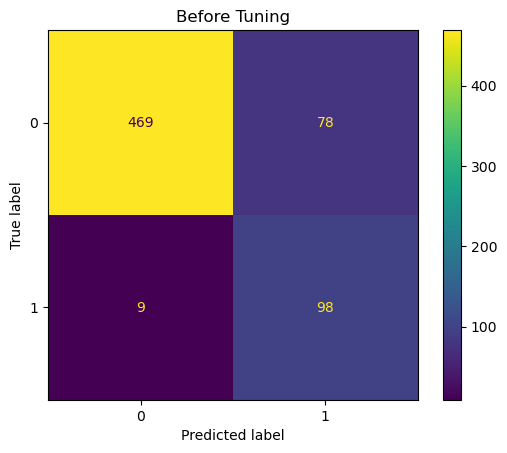

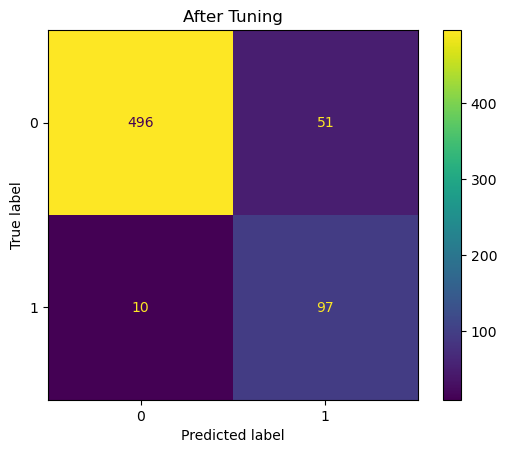

In [59]:
# sebelum tuning
disp_before = ConfusionMatrixDisplay(confusion_matrix=cm_before_lgbm)
disp_before.plot()
plt.title('Before Tuning')

# setelah tuning
disp_after = ConfusionMatrixDisplay(confusion_matrix=cm_after_lgbm)
disp_after.plot()
plt.title('After Tuning')

plt.show()

Kesimpulan:

- TP --> aktual churn, prediksi churn
- TN --> aktual not churn, prediksi not churn
- FP --> aktual not churn, prediksi churn
- FN --> aktual churn, prediksi not churn

Hasil confusion matrix model LGBMClassifier sebelum tuning:
|  | **Sebelum tuning** | **Setelah Tuning** |
| -------- | ------------ | ------------- |
| TP | 98 | 97 |
| TN | 469 | 496 |
| FP | 78 | 51 |
| FN | 9 | 10 |

Biaya retensi = $20
<br>
Biaya akuisisi customer baru = $100

Biaya yang dikeluarkan jika menggunakan ML:
|  | **Sebelum Tuning** | **Total biaya sebelum tuning** | **Setelah Tuning** | **Total biaya setelah tuning** |
| -------- | ------------ | ------------- | ------------ | ------------- |
| TP | 98 x $20 | $1960 | 97 x $20 | $1940 |
| TN | 469 x 0 | 0 | 496 x 0 | 0 |
| FP | 78 x $20 | $1560 | 51 x $20 | $1020 |
| FN | 9 x $100 | $900 | 10 x $100 | $1000 |
|  | Total biaya sebelum tuning | $4420 | Total biaya sesudah tuning | **$3960** |

- **XGBClassifier**

In [60]:
# confusion matrix sebelum tuning
cm_before_xgb = confusion_matrix(y_test, y_pred_before_xgb)

In [61]:
# confusion matrix setelah tuning
cm_after_xgb = confusion_matrix(y_test, y_pred_tuning_xgb)

In [62]:
cm_before_xgb, cm_after_xgb

(array([[461,  86],
        [ 10,  97]], dtype=int64),
 array([[493,  54],
        [ 13,  94]], dtype=int64))

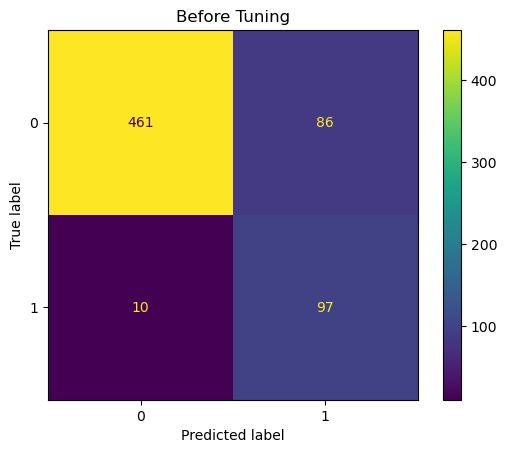

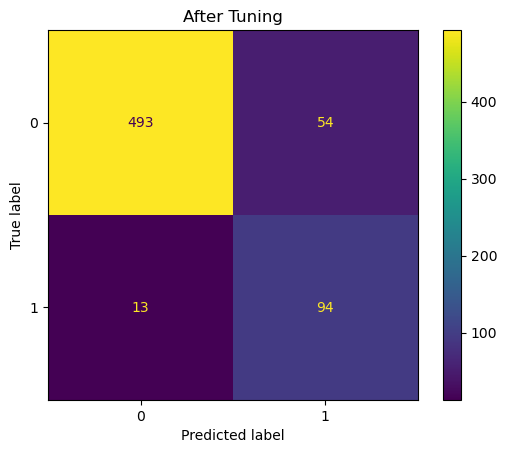

In [63]:
# sebelum tuning
disp_before = ConfusionMatrixDisplay(confusion_matrix=cm_before_xgb)
disp_before.plot()
plt.title('Before Tuning')

# setelah tuning
disp_after = ConfusionMatrixDisplay(confusion_matrix=cm_after_xgb)
disp_after.plot()
plt.title('After Tuning')

plt.show()

Kesimpulan:

Hasil confusion matrix model XBGClassifier sebelum tuning:
|  | **Sebelum tuning** | **Sesudah Tuning** |
| -------- | ------------ | ------------- |
| TP | 97 | 94 |
| TN | 461 | 493 |
| FP | 86 | 54 |
| FN | 10 | 13 |

Biaya retensi = $20
<br>
Biaya akuisisi customer baru = $100

Biaya yang dikeluarkan jika menggunakan ML:
|  | **Sebelum Tuning** | **Total biaya sebelum tuning** | **Sesudah Tuning** | **Total biaya sesudah tuning** |
| -------- | ------------ | ------------- | ------------ | ------------- |
| TP | 97 x $20 | $1940 | 94 x $20 | $1880 |
| TN | 461 x 0 | 0 | 493 x 0 | 0 |
| FP | 86 x $20 | $1720 | 54 x $20 | $1080 |
| FN | 10 x $100 | $1000 | 13 x $100 | $1300 |
|  | Total biaya sebelum tuning | $4660 | Total biaya sesudah tuning | $4260 |

In [64]:
print(classification_report(y_test, y_pred_tuning_lgbm))

              precision    recall  f1-score   support

           0       0.98      0.91      0.94       547
           1       0.66      0.91      0.76       107

    accuracy                           0.91       654
   macro avg       0.82      0.91      0.85       654
weighted avg       0.93      0.91      0.91       654



In [65]:
y_test.value_counts()

Churn
0    547
1    107
Name: count, dtype: int64

In [66]:
(((13080 - 3960)/13080)*100).__round__(0)

70.0

Kesimpulan:

- Biaya yang dikeluarkan jika tidak menggunakan Machine Learning (ML):
<br>
Biaya retensi untuk semua pelanggan (biaya sangat besar dan tidak efisien) = 654 * $20 = **$13080**
<br>
Biaya yang dikeluarkan sia-sia karena biaya retensi diberikan kepada pelanggan yang tidak churn = 547 * $20 = $10940

- Biaya yang dikeluarkan jika menggunakan ML:
Model yang digunakan adalah LGBMClassifier setelah tuning.
<br>
Biaya = **$3960**

Cost saving = $13080 - $3960 = $9120
<br>
Persentase cost saving = ($9120 / $13080) * 100% = 70%

Jika menggunakan model machine learning **LGBMClassifier** untuk melakukan prediksi maka perusahaan dapat menghemat biaya sebesar **$9120** atau **70%** dari biaya yang dialokasikan untuk retensi.

## Shapley Value of Explanations (SHAP)

SHAP digunakan untuk menjelaskan output dari model ML. Untuk mengetahui kontribusi setiap fitur terhadap prediksi model, maka visualisasi SHAP digunakan agar mempermudah interpretasi hasil prediksi model.

In [67]:
col_names = random_lgbm.best_estimator_['transformer'].get_feature_names_out()
col_names

array(['pipe_imp_robust__Tenure', 'pipe_imp_robust__WarehouseToHome',
       'pipe_imp_robust__NumberOfDeviceRegistered',
       'pipe_imp_robust__SatisfactionScore',
       'pipe_imp_robust__NumberOfAddress',
       'pipe_imp_robust__DaySinceLastOrder',
       'pipe_imp_robust__CashbackAmount',
       'encoding__PreferedOrderCat_Fashion',
       'encoding__PreferedOrderCat_Grocery',
       'encoding__PreferedOrderCat_Laptop & Accessory',
       'encoding__PreferedOrderCat_Mobile',
       'encoding__PreferedOrderCat_Mobile Phone',
       'encoding__PreferedOrderCat_Others',
       'encoding__MaritalStatus_Divorced',
       'encoding__MaritalStatus_Married',
       'encoding__MaritalStatus_Single', 'remainder__Complain'],
      dtype=object)

In [68]:
?shap.TreeExplainer

Init signature:
shap.TreeExplainer(
    model,
    data=None,
    model_output='raw',
    feature_perturbation='auto',
    feature_names=None,
    approximate=<object object at 0x00000232B651BEC0>,
    link=None,
    linearize_link=None,
)
Docstring:     
Uses Tree SHAP algorithms to explain the output of ensemble tree models.

Tree SHAP is a fast and exact method to estimate SHAP values for tree models
and ensembles of trees, under several different possible assumptions about
feature dependence. It depends on fast C++ implementations either inside an
external model package or in the local compiled C extension.

Examples
--------
See `Tree explainer examples <https://shap.readthedocs.io/en/latest/api_examples/explainers/Tree.html>`_
Init docstring:
Build a new Tree explainer for the passed model.

Parameters
----------
model : model object
    The tree based machine learning model that we want to explain.
    XGBoost, LightGBM, CatBoost, Pyspark and most tree-based
    scikit-learn mod

In [69]:
my_model = random_lgbm.best_estimator_[-1]
my_data = random_lgbm.best_estimator_[0].transform(x_train)

explainer_shap = shap.TreeExplainer(
    model= my_model,
    data= my_data
)

shap_values = explainer_shap.shap_values(my_data)

 94%|=================== | 2468/2616 [00:14<00:00]       

In [70]:
# nama fitur
feat_scale = random_lgbm.best_estimator_['transformer'].transformers_[0][2]
feat_onehot = list(random_lgbm.best_estimator_['transformer'].transformers_[1][1].get_feature_names_out())
feat_remainder = list(x.columns[random_lgbm.best_estimator_['transformer'].transformers_[2][2]])

feat = feat_scale + feat_onehot + feat_remainder
feat

['Tenure',
 'WarehouseToHome',
 'NumberOfDeviceRegistered',
 'SatisfactionScore',
 'NumberOfAddress',
 'DaySinceLastOrder',
 'CashbackAmount',
 'PreferedOrderCat_Fashion',
 'PreferedOrderCat_Grocery',
 'PreferedOrderCat_Laptop & Accessory',
 'PreferedOrderCat_Mobile',
 'PreferedOrderCat_Mobile Phone',
 'PreferedOrderCat_Others',
 'MaritalStatus_Divorced',
 'MaritalStatus_Married',
 'MaritalStatus_Single',
 'Complain']

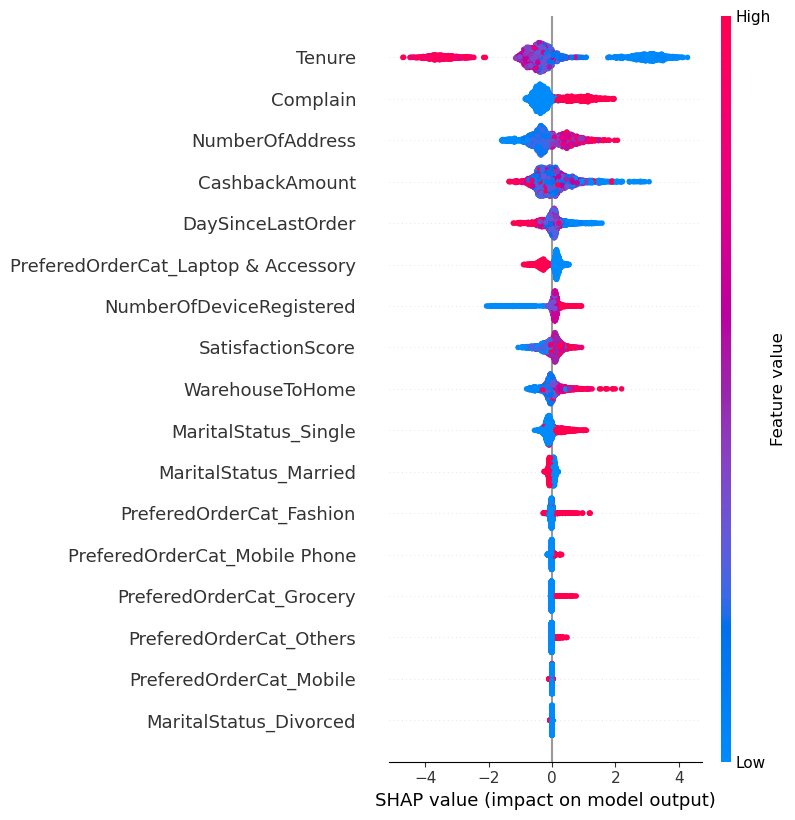

In [71]:
shap.summary_plot(shap_values, my_data, feature_names=feat)

Interpretasi:
- Pelanggan dengan Tenure yang rendah cenderung churn, dan pelanggan dengan Tenure yang tinggi cenderung tidak churn. Pelanggan baru cenderung churn.
- Pelanggan yang komplain cenderung churn, dan pelanggan yang tidak komplain cenderung tidak churn.
- Pelanggan yang mendapatkan cashback rendah cenderung churn.
- Pelanggan dengan Satisfaction Score tinggi cenderung churn.
- Pelanggan yang memiliki rumah dengan jarak yang jauh dari gudang cenderung churn.
- Pelanggan dengen preferensi kategori Laptop dan Accessory cenderung tidak churn.

## Conclusion & Recomendation

**Model limitation**

Model ini hanya akan relevan untuk data dengan range nilai tertentu, yaitu:
- `Tenure` : 0 hingga 61
- `WarehouseToHome` : 5 hingga 127
- `NumberOfDeviceRegistered` : 1 hingga 6 perangkat
- `SatisfactionScore` : skor 1 hingga 5
- `NumberOfAddress` : 1 hingga 22 alamat
- `DaySinceLastOrder` : 0 hingga 46 hari
- `CashbackAmount` : 0 hingga 324.99

**Conclusion**

Proses pemodelan dilakukan untuk mendapatkan model machine learning dengan performa terbaik dalam memprediksi pelanggan yang akan churn atau tidak churn. Metrik yang digunakan adalah F2-score. Model yang paling baik dalam memprediksi customer churn adalah model **LGBMClassifier** dengan kombinasi hyperparameter terbaik hasil hyperparameter tuning. 
<br>
Tanpa menggunakan model machine learning, strategi retensi yang dilakukan adalah memberikan promo kepada semua pelanggan tanpa prediksi dan biaya yang dikeluarkan sebesar 654 x $20 = **$13080**.
<br>
Dengan menggunakan model machine learning, perusahaan dapat mengetahui prediksi pelanggan yang churn atau tidak. Strategi retensi yang diberikan dapat lebih tepat sasaran dan efisien. Biaya yang dikeluarkan perusahaan jika menggunakan model machine learning adalah sebesar **$3960**.

Perusahaan dapat menghemat biaya sebesar 70% atau $9120 untuk mempertahankan pelanggan yang akan churn. Perusahaan dapat menerapkan model machine learning untuk melakukan prediksi customer churn agar strategi retensi yang dilakukan lebih efisien.

**Recommendation**
- Untuk Model ML:
    - Menambahkan fitur atau kolom baru yang berkaitan dengan customer churn sehingga dapat meningkatkan performa model.
    - Menambah jumlah data untuk dipelajari oleh machine learning agar dapat menghasilkan model yang lebih akurat dalam melakukan prediksi.
    - Melakukan explorasi terhadap kombinasi hyperparameter yang diuji dalam proses tuning untuk meningkatkan performa model.

- Untuk bisnis:
    - Menggunakan model machine learning untuk memprediksi customer churn sehingga dapat menjalankan strategi retensi yang tepat sasaran.
    - Memberikan promo atau cashback kepada pelanggan yang baru bergabung atau menggunakan platform e-commerce.
    - Menangani komplain dari customer untuk menjaga kepuasan customer terhadap layanan e-commerce.
    - Memberikan potongan biaya pengiriman untuk customer yang memiliki alamat jauh dari gudang.
    - Evaluasi lebih lanjut terkait kepuasan pelanggan karena customer dengan satisfaction score tinggi cenderung churn.


## Save model

Model machine learning disimpan agar user dapat memprediksi apakah pelanggan akan churn atau tidak dengan memasukkan nilai-nilai dari fitur yang ada. 

In [72]:
# best model
best_model = random_lgbm.best_estimator_
best_model

# fit
best_model.fit(x, y)

# save with pickle
pickle.dump(best_model, open('model_lgbmclassifier_m3.sav', 'wb'))

## Load Model

In [73]:
# load model

model_loaded = pickle.load(open('model_lgbmclassifier_m3.sav', 'rb'))
model_loaded

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipe_imp_robust',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('robust',
                                                                   RobustScaler())]),
                                                  ['Tenure', 'WarehouseToHome',
                                                   'NumberOfDeviceRegistered',
                                                   'SatisfactionScore',
                                                   'NumberOfAddress',
                                                   'DaySinceLastOrder',
                                                   'CashbackAmount']),
                                                 ('encoding', OneHotEncoder(),
                                                  ['PreferedOrderCat',
                                                   'MaritalStatus'])])),
                ('resampling', None),
                ('model',
                 LGBMClassifier(class_weight='balanced', learning_rate=0.08,
                                n_estimator=225, num_leaves=21, random_state=42,
                                verbosity=-1))])

In [78]:
def user_input_feature():

    df = pd.DataFrame()
    df['Tenure'] = [10]
    df['WarehouseToHome'] = [15]
    df['NumberOfDeviceRegistered'] = [4]
    df['PreferedOrderCat'] = ['Mobile Phone']
    df['SatisfactionScore'] = [1]
    df['MaritalStatus'] = ['Single']
    df['NumberOfAddress'] = [3]
    df['Complain'] = [1]
    df['DaySinceLastOrder'] = [10]
    df['CashbackAmount'] = [100]

    return df

In [79]:
df_customer = user_input_feature()
df_customer

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount
0,10,15,4,Mobile Phone,1,Single,3,1,10,100


In [80]:
kelas = model_loaded.predict(df_customer)

if kelas == 1:
    print('Class 1: This customer will CHURN')
else:
    print('Class 0: This customer will STAY')

Class 0: This customer will STAY
